In [1]:
install.packages("remotes")
remotes::install_github("silkeszy/Pomona")
# caret and reshape2 I had to install via conda
pacman::p_load(readr,dplyr,tibble,ranger,mlr,tuneRanger,tidyr,
               data.table,ggplot2,vegan,Pomona,caret,reshape2,cowplot,tidyverse,viridis)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Skipping install of 'Pomona' from a github remote, the SHA1 (2283f732) has not changed since last install.
  Use `force = TRUE` to force installation



In [2]:
eukaryotic_taxonomy = data.frame(fread(file.path("..","data","2021-marzoanmmetsp-estimated-taxonomy.csv"))) %>%
            dplyr::filter(taxonomy != '-;-;-;-;-;-')
prokaryotic_taxonomy = data.frame(fread(file.path("..","data","prokaryote_taxonomy.csv")))

set.seed(1)

# functions ----------------------------

# Author: Taylor Reiter ----------------
ggplotConfusionMatrix <- function(m, plot_title = NULL){
  library(ggplot2)
  library(scales)
  library(tidyr)
  mycaption <- paste("Accuracy", percent_format()(m$overall[1]),
                     "Kappa", percent_format()(m$overall[2]))
  #mycaption <- paste("Accuracy", percent_format()(m$overall[1]))
  p <-
    ggplot(data = as.data.frame(m$table) ,
           aes(x = Reference, y = Prediction)) +
    geom_tile(aes(fill = log(Freq)), colour = "white") +
    scale_fill_gradient(low = "white", high = "steelblue") +
    geom_text(aes(x = Reference, y = Prediction, label = Freq)) +
    theme_minimal() +
    theme(legend.position = "none", 
          text = element_text(size = 9),
          axis.text.x = element_text(angle = 30, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5)) +
    labs(caption = mycaption, title = plot_title)
  return(p)
}

# Author: Taylor Reiter ----------------
evaluate_model <- function(optimal_ranger, data, reference_class, plt_title) {
  library(ranger)
  library(readr)
  
  # calculate prediction accuracy
  pred <- predict(optimal_ranger, data)
  pred_tab <- table(observed = reference_class, predicted = pred$predictions)
  print(pred_tab)
  
  # calculate performance
  performance <- sum(diag(pred_tab)) / sum(pred_tab)
  print(paste0("ACCURACY = ", performance))
  
  # plot pretty confusion matrix
  cm <- confusionMatrix(data = pred$predictions, reference = reference_class)
  ggplotConfusionMatrix(cm, plot_title = plt_title)
  # ggsave(filename = confusion_pdf, plot = plt, scale = 1, width = 6, height = 4, dpi = 300)
}

#' Copy the taxonomy and return whether a eukaryote or a prokaryote
#' and its taxonomy string.
# Author: Arianna Krinos ----------------
get_euk_prok <- function(genome_names) {
    modified_df = data.frame("Genome" = genome_names)
    modified_df = modified_df %>% 
        dplyr::left_join(eukaryotic_taxonomy, by = c("Genome" = "mag")) %>%
        dplyr::left_join(prokaryotic_taxonomy, by = "Genome") %>%
        dplyr::select(Genome,taxonomy,classification)
    modified_df = modified_df %>% 
        dplyr::mutate(taxonomy = replace_na(taxonomy, ""),
                      classification = replace_na(classification, "")) %>%
        mutate(taxonomy = replace(taxonomy, classification != "", "")) %>%
        dplyr::mutate(no_classification = ifelse(((taxonomy == "") | 
                                                  (taxonomy == '-;-;-;-;-;-')) & 
                                                 (classification == ""), 
                                                 "none", "")) %>%
        pivot_longer(
           cols = c("classification","no_classification","taxonomy"),
           names_to = "classification_type",
           values_to = "classification"
        ) %>% 
        dplyr::filter(classification != "") %>%
        dplyr::filter(classification != '-;-;-;-;-;-') %>%
        dplyr::mutate(EukOrProk = factor(classification_type)) 
    modified_df$EukOrProk = as.character(modified_df$EukOrProk)
    modified_df$EukOrProk[modified_df$EukOrProk == "taxonomy"] = "euk"
    modified_df$EukOrProk[modified_df$EukOrProk == "classification"] = "prok"
    modified_df$EukOrProk[modified_df$EukOrProk == "no_classification"] = "unclass"
    return(modified_df)
}

# Author: Arianna Krinos ----------------
select_KOs <- function(mmetsp_allfeatures,selected_kos) {
    # Put the KO annotations with the MMETSP KO data
    ko_merged = mmetsp_allfeatures %>% 
                tidyr::pivot_longer(cols = (starts_with("K") & !(starts_with("Ke"))),
                                    names_to="KEGG_ID_NUM") %>%
                dplyr::filter(KEGG_ID_NUM %in% selected_kos)
    ko_merged = ko_merged %>% 
        dplyr::distinct(KEGG_ID_NUM,Source_ID,.keep_all=TRUE) %>%
        tidyr::pivot_wider(names_from =KEGG_ID_NUM,values_from=value,id_cols=Source_ID,values_fn=mean)
    return(ko_merged)
}

# Author: Arianna Krinos ----------------
generate_scores_selected_features <- function(mmetsp_allfeatures,selected_kos) {
    # Put the KO annotations with the MMETSP KO data
    ko_merged = mmetsp_allfeatures %>% 
                tidyr::pivot_longer(cols = (starts_with("K") & !(starts_with("Ke"))),
                                    names_to="KEGG_ID_NUM") %>%
                dplyr::filter(KEGG_ID_NUM %in% selected_kos)
    
    # Truncate important columns in matrix
    ko_merged_trunc = ko_merged[c("Source_ID","Trophic.mode","KEGG_ID_NUM","value")]
    
    # Sum KO results
    ko_summed = ko_merged_trunc %>%
                dplyr::group_by(Trophic.mode,KEGG_ID_NUM) %>%
                dplyr::summarize(summed = sum(value))

    # Get total counts of KOs
    ko_counted = ko_merged_trunc %>%
                dplyr::group_by(Trophic.mode,KEGG_ID_NUM) %>%
                dplyr::summarize(total = n())
    
    # Filter out KOs below a certain level of consensus
    merged_results = ko_summed %>% dplyr::inner_join(ko_counted, by = c("KEGG_ID_NUM","Trophic.mode")) %>%
                        dplyr::mutate(Ratio = summed / total) %>%
                        dplyr::mutate(ProbSuccess = Ratio) %>%
                        dplyr::rename("Predicted.trophic.mode" = "Trophic.mode") %>%
                        dplyr::distinct(Predicted.trophic.mode,KEGG_ID_NUM,.keep_all = TRUE)

    return(merged_results)
}

# input the vector of probabilities for each of the KEGGs generated from the MMETSP
# Author: Arianna Krinos ----------------
generate_point_values <- function(vect_probabilities) {
    votes_ret = data.frame("Prob" = vect_probabilities) %>%
            dplyr::mutate(votes = case_when(Prob < 0.5 ~ (-(0.5-Prob)),
                                            Prob >= 0.5 ~ Prob))
    return(votes_ret$votes)
}

# Author: Arianna Krinos ----------------
sum_up_votes <- function(vect_binary_values, votes_vect) {
    votes_summed_df = data.frame("Binary" = vect_binary_values,
                                 "Votes" = votes_vect)
    votes_summed_df$ModVote = votes_summed_df$Votes
    votes_summed_df$ModVote[which(votes_summed_df$Binary == 0)] = -votes_summed_df$Vote[
        which(votes_summed_df$Binary == 0)]
    return(floor(sum(votes_summed_df$ModVote)))
}

# Author: Arianna Krinos ----------------
classify_points_binom <- function(KOmatrix_topredict, model_matrix, id_col_name) {
    # Convert sample KO matrix to long format
    KOmatrix_topredict["Source_ID"] = KOmatrix_topredict[id_col_name]
    formatted_KOmatrix_long = KOmatrix_topredict %>% 
                tidyr::pivot_longer(cols = (starts_with("K") & !(starts_with("Ke"))),
                                    names_to="KEGG_ID_NUM")
    
    # Merge the matrix of model scores with the test data
    formatted_KOmatrix_topredict = model_matrix %>% 
                                   dplyr::select(KEGG_ID_NUM,Predicted.trophic.mode,ProbSuccess) %>%
                                   dplyr::inner_join(formatted_KOmatrix_long %>% 
                                                     dplyr::select(KEGG_ID_NUM,value,Source_ID)
                                                     , by = "KEGG_ID_NUM") %>%
                                   arrange(KEGG_ID_NUM)
    model_matrix = model_matrix %>% arrange(KEGG_ID_NUM)
    
    formatted_KOmatrix_topredict["Votes"] = generate_point_values(formatted_KOmatrix_topredict$ProbSuccess)
    
    vote_matrix = formatted_KOmatrix_topredict %>%
        dplyr::group_by(Source_ID,Predicted.trophic.mode) %>%
        group_modify(~ {
         sum_up_votes(.x$value, .x$Votes) %>%
         tibble::enframe(value = "Score")
        })
    
    results_matrix = vote_matrix %>% 
            tidyr::pivot_wider(names_from = Predicted.trophic.mode,
                               values_from = Score, id_cols = "Source_ID")
    
    # Generate point vectors for each trophic mode.
    heterotroph_points_vect = generate_point_values(as.numeric((model_matrix %>% 
                                    dplyr::filter(Predicted.trophic.mode == "Heterotroph"))$ProbSuccess))
    mixotroph_points_vect = generate_point_values(as.numeric((model_matrix %>% 
                                    dplyr::filter(Predicted.trophic.mode == "Mixotroph"))$ProbSuccess))
    phototroph_points_vect = generate_point_values(as.numeric((model_matrix %>% 
                                    dplyr::filter(Predicted.trophic.mode == "Phototroph"))$ProbSuccess))
    
    results_matrix = results_matrix %>%
        dplyr::mutate(HeterotrophyScore = case_when(
                                  (Mixotroph - max(Heterotroph,Phototroph)) < 50 ~ sign(Heterotroph-Phototroph)*
                                                  (sqrt((Heterotroph-Phototroph)^2)),
                                  Mixotroph > 0 ~ sign(Heterotroph-Phototroph)*
                                                  (sqrt((Heterotroph-Phototroph)^2)) / Mixotroph,
            #^(1/Mixotroph),
                                                  #-sign(Heterotroph-Phototroph) * Mixotroph,
                                  Mixotroph <= 0 ~ sign(Heterotroph-Phototroph)*
                                                    sqrt((Heterotroph-Phototroph)^2)
                                )) %>%
        dplyr::mutate(Predicted.trophic.mode = case_when(
                                HeterotrophyScore > 5 ~ "Heterotroph",
                                HeterotrophyScore < -5 ~ "Phototroph",
                                TRUE ~ "Mixotroph"
                                ))
    predicted_modes_byindex = results_matrix[c("Source_ID","HeterotrophyScore","Predicted.trophic.mode")]
    predicted_modes_byscore = vote_matrix %>% 
                                group_by(Source_ID) %>%
                                filter(Score == max(Score)) 
    return(list(vote_matrix, predicted_modes_byindex, predicted_modes_byscore))
}

In [3]:
##### READ IN REQUIRED DATA #####
## CANDIDATE MAGS ##
kegg_mag_annotation = read.csv(file.path("..","data","MAG_keggannot.csv"))
new_columns = c("MAG", colnames(kegg_mag_annotation)[2:length(colnames(kegg_mag_annotation))])
colnames(kegg_mag_annotation) = new_columns

## MMETSP INPUT INFO ##
kegg_mmetsp_annotation = read.csv(file.path("..","data","MMETSP_keggannot.csv"))
new_columns = c("Source_ID", colnames(kegg_mmetsp_annotation)[2:length(colnames(kegg_mmetsp_annotation))])
colnames(kegg_mmetsp_annotation) = new_columns

# These MAGs have low completeness per Harriet
suspicious_MAGs = c("MMETSP1147","MMETSP1148","MMETSP0018","MMETSP0252","MMETSP0924","MMETSP1019",
                   "MMETSP0451","MMETSP0225","MMETSP0210","MMETSP0186","MMETSP0251","MMETSP1018",
                   "MMETSP0398","MMETSP0132","MMETSP1317","MMETSP0229","MMETSP0196","MMETSP0798",
                   "MMETSP0922","MMETSP0044","MMETSP0347","MMETSP0223")
kegg_mmetsp_annotation = kegg_mmetsp_annotation %>% dplyr::filter(!(Source_ID %in% suspicious_MAGs))

## MMETSP TROPHY ANNOTATIONS ##
mmetsp_trophy_annotation = read.csv(file.path("..","data","2020-12-mmetsp-trophy-skh.csv"))

## KO INFORMATION ##
ko_conversion = read.csv(file.path("..","data","ko_koID_to_metaD.txt"), sep = "\t")
ko_conversion = ko_conversion %>%
                tidyr::separate(briteTopL_pathMapID_class_pathway_geneName_geneDesc,
                                sep = ";", 
                                into = strsplit("briteTopL_pathMapID_class_pathway_geneName_geneDesc","_")[[1]]) %>%
                tidyr::separate(koID, sep = ":", into = c("KO","IDnum")) %>%
                dplyr::distinct(IDnum, .keep_all = TRUE)
ko_conversion$KEGG_ID_NUM = 0
for (index_curr in c(1:length(ko_conversion$KEGG_ID_NUM))) {
    curr_split = strsplit(ko_conversion$IDnum[index_curr],"K")[[1]][2]
    ko_conversion$KEGG_ID_NUM[index_curr] = as.numeric(curr_split)
}

## EUKPROT INPUTS ##
kegg_euk_prot = data.frame(fread(file.path("/vortexfs1","omics","alexander","share","EukProt_kegganot.csv")))
kegg_euk_prot["sumVar"] = rowSums(kegg_euk_prot %>% dplyr::select(starts_with("K")))
kegg_euk_prot_complete = kegg_euk_prot %>%
                             dplyr::filter(sumVar > 500) %>%
                             tidyr::separate(V1, into = c("EPID","Genus","Species",
                                                          "Species2","Species3"), sep = "_") %>%
                             unite("Tax", c("Genus","Species","Species2",
                                            "Species3"), remove = TRUE, na.rm = TRUE)

euk_prot_trophy = data.frame(fread(file.path("..","data","eukprot_trophy.csv")))
euk_prot_trophy$Full_Name = euk_prot_trophy$Name_to_Use
for (id in kegg_euk_prot_complete$Tax) {
    euk_prot_trophy$Name_to_Use[which(grepl(id,euk_prot_trophy$Name_to_Use))] = id
}
merged_annotations = euk_prot_trophy %>% dplyr::select(c("Name_to_Use","Taxonomy_UniEuk","Keep","Trophic.mode")) %>%
                        dplyr::left_join(kegg_euk_prot_complete, by = c("Name_to_Use" = "Tax"))
merged_annotations_eukprot = merged_annotations %>% dplyr::filter(Keep == 1) %>%
                                tidyr::drop_na(EPID)
# Convert EukProt annotations to features
kegg_eukprok_annotation = merged_annotations_eukprot %>% dplyr::select(starts_with('K'))

mmetsp_allfeatures = kegg_mmetsp_annotation %>%
                         dplyr::inner_join(mmetsp_trophy_annotation,by = c("Source_ID"="Source_ID"))
eukprot_withtax = merged_annotations_eukprot %>% tidyr::separate(Taxonomy_UniEuk,sep=";",
                                                    into=c("Domain","Supergroup","MajorClade","Clade",
                                                           "Division","Class"))
all_tax_info = mmetsp_allfeatures %>% dplyr::bind_rows(eukprot_withtax)

Warning message:
“Expected 5 pieces. Missing pieces filled with `NA` in 370 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Warning message:
“Expected 6 pieces. Additional pieces discarded in 271 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 3 rows [54, 109, 110].”


In [4]:
all_tax_info = mmetsp_allfeatures %>% dplyr::bind_rows(eukprot_withtax)

In [36]:
##### GENERATE TEST SET #####
# Generate a test set from randomly selected eukprot+mmetsp
k_cols = colnames(mmetsp_allfeatures)[grepl("K",colnames(mmetsp_allfeatures))]
mmetsp_allfeatures_test = mmetsp_allfeatures[c("Source_ID","Trophic.mode",k_cols)]
k_cols = colnames(merged_annotations_eukprot)[grepl("K",colnames(merged_annotations_eukprot))]
eukprot_allfeatures_test = merged_annotations_eukprot[c("Name_to_Use","Trophic.mode",k_cols)]
eukprot_allfeatures_test = eukprot_allfeatures_test %>% 
                        rename(Source_ID = "Name_to_Use")
all_test_data = eukprot_allfeatures_test %>% dplyr::bind_rows(mmetsp_allfeatures_test)

train_rows = all_test_data %>% sample_frac(0.75)
test_rows = all_test_data %>% dplyr::filter(!(Source_ID %in% train_rows$Source_ID))

#write.csv(test_rows,paste0("test_set_",as.character(Sys.Date()),".csv"))
#write.csv(train_rows,paste0("train_set_",as.character(Sys.Date()),".csv"))

In [6]:
k_cols = colnames(mmetsp_allfeatures)[grepl("K",colnames(mmetsp_allfeatures))]
mmetsp_allfeatures_test = mmetsp_allfeatures[c("Source_ID","Trophic.mode",k_cols)]
k_cols = colnames(merged_annotations_eukprot)[grepl("K",colnames(merged_annotations_eukprot))]
eukprot_allfeatures_test = merged_annotations_eukprot[c("Name_to_Use","Trophic.mode",k_cols)]
eukprot_allfeatures_test = eukprot_allfeatures_test %>% 
                        rename(Source_ID = "Name_to_Use")
all_test_data = eukprot_allfeatures_test %>% dplyr::bind_rows(mmetsp_allfeatures_test)

In [5]:
test_rows = read.csv(file.path("..","tables","test_set_2021-03-06.csv"))
train_rows = read.csv(file.path("..","tables","train_set_2021-03-06.csv"))
vita = readRDS(file.path("..","data",paste0("vita_model_seed12021-03-06.RDS")))

In [ ]:
##### VARIABLE SELECTION #####
# var.sel.vita calculates p-values based on the empirical null distribution
# from non-positive VIMs as described in Janitza et al. (2015).
vita <- Pomona::var.sel.vita(x = train_rows %>% dplyr::select(starts_with("K") & !starts_with("Ke")), 
                     y = train_rows$Trophic.mode, p.t = 0.05,
                     ntree = 10000, mtry.prop = 0.2, nodesize.prop = 0.1,
                     no.threads = 3, method = "ranger", type = "classification")
saveRDS(vita, file.path("..","..","output",paste0("vita_model_seed1",as.character(Sys.Date()),".RDS")))

In [5]:
write.csv(data.frame("Selected KOs" = vita$var),file.path("..","tables","vita_selected_vars.csv"),row.names=FALSE)

In [7]:
vita_vars = read.csv(file.path("..","tables","vita_selected_vars.csv"))
vita_vars = vita_vars$Selected.KOs

In [8]:
ko_info_vita = ko_conversion %>% dplyr::filter(IDnum %in% vita_vars)

In [9]:
length(unique(ko_conversion$IDnum))
length(unique(vita_vars))

[1] 21585

[1] 1787

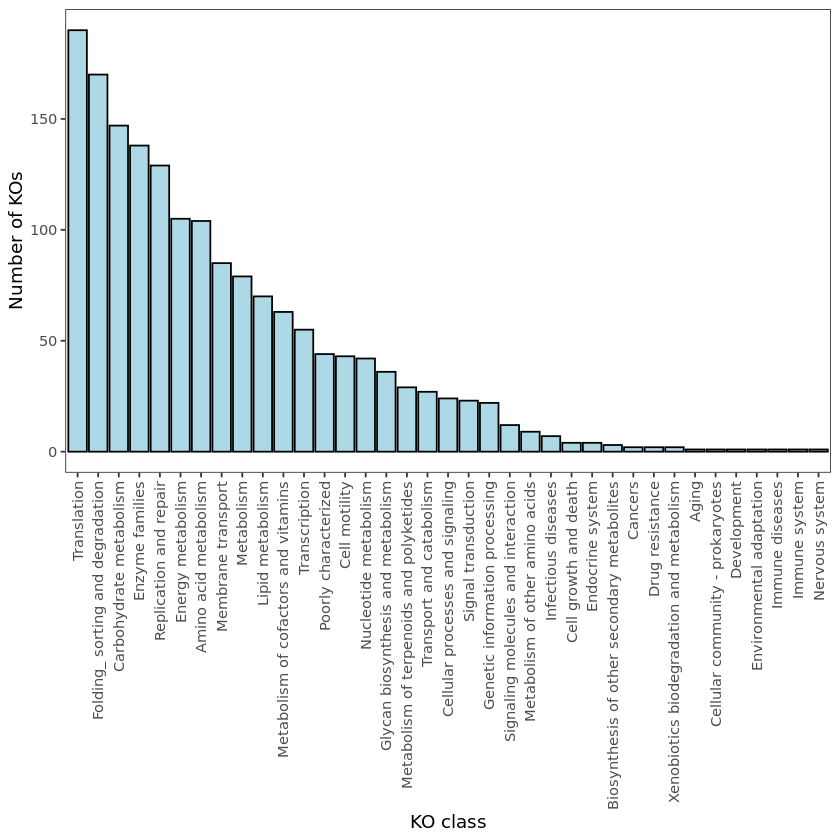

In [10]:
class_summary = ko_info_vita %>% dplyr::group_by(class) %>% dplyr::tally() %>%
  mutate(class = fct_reorder(class, desc(n)))
ggplot(class_summary) + 
    geom_bar(aes(x = class, y = n),stat="identity",fill = "light blue",col="black") + 
    theme_test() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    xlab("KO class") + ylab("Number of KOs")

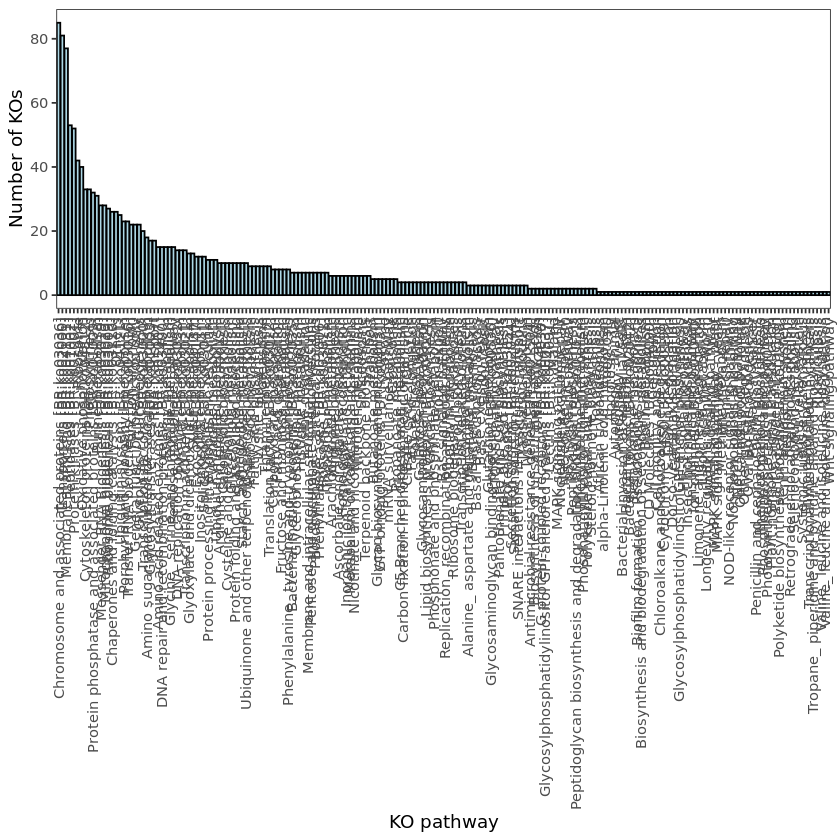

In [11]:
pathway_summary = ko_info_vita %>% dplyr::group_by(pathway) %>% dplyr::tally() %>%
  mutate(pathway = fct_reorder(pathway, desc(n)))
ggplot(pathway_summary) + 
    geom_bar(aes(x = pathway, y = n),stat="identity",fill = "light blue",col="black") + 
    theme_test() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    xlab("KO pathway") + ylab("Number of KOs")
ggsave("ko_pathways.png",width=20,height=8,units="in")

In [12]:
# Heterotrophy index model
training_scores = generate_scores_selected_features(train_rows, vita$var)

`summarise()` has grouped output by 'Trophic.mode'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Trophic.mode'. You can override using the `.groups` argument.



`summarise()` has grouped output by 'Predicted.trophic.mode'. You can override using the `.groups` argument.



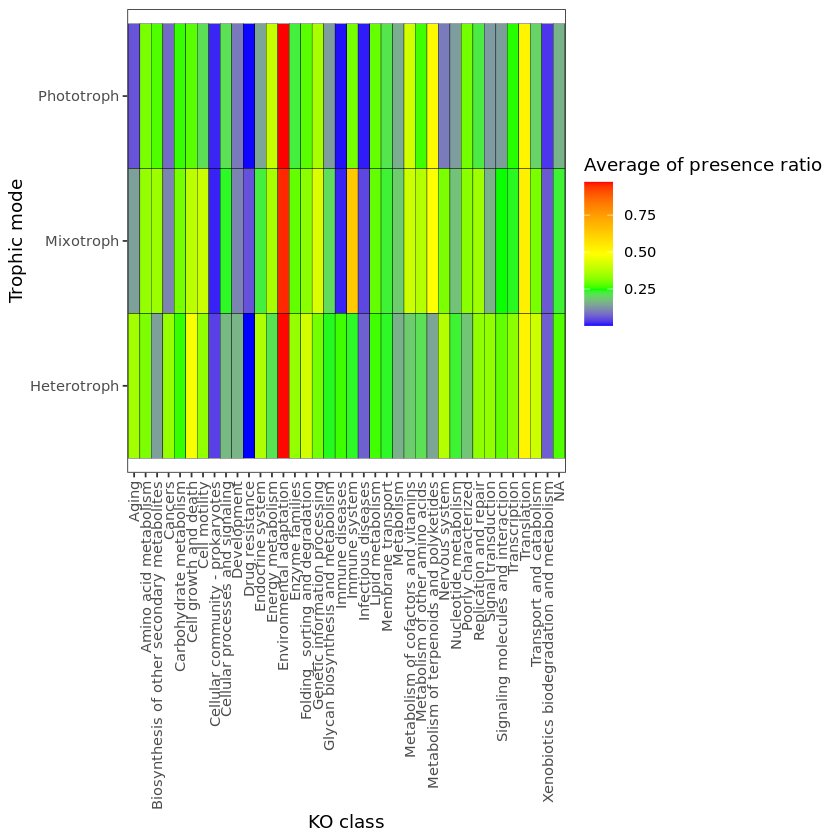

In [13]:
scores_with_KOs = training_scores %>% dplyr::left_join(ko_info_vita, by = c("KEGG_ID_NUM" = "IDnum"))
tm_kos = scores_with_KOs %>% dplyr::group_by(Predicted.trophic.mode,class) %>% 
            dplyr::summarize(MeanRatio = mean(Ratio))
ggplot(tm_kos) + geom_tile(aes(x = class, y = Predicted.trophic.mode, fill = MeanRatio),
                           col="black") + scale_fill_gradientn(colors=c("blue","green",
                                                                       "yellow","orange","red"),
                                                              name = "Average of presence ratio") +
    theme_test() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    xlab("KO class") + ylab("Trophic mode")

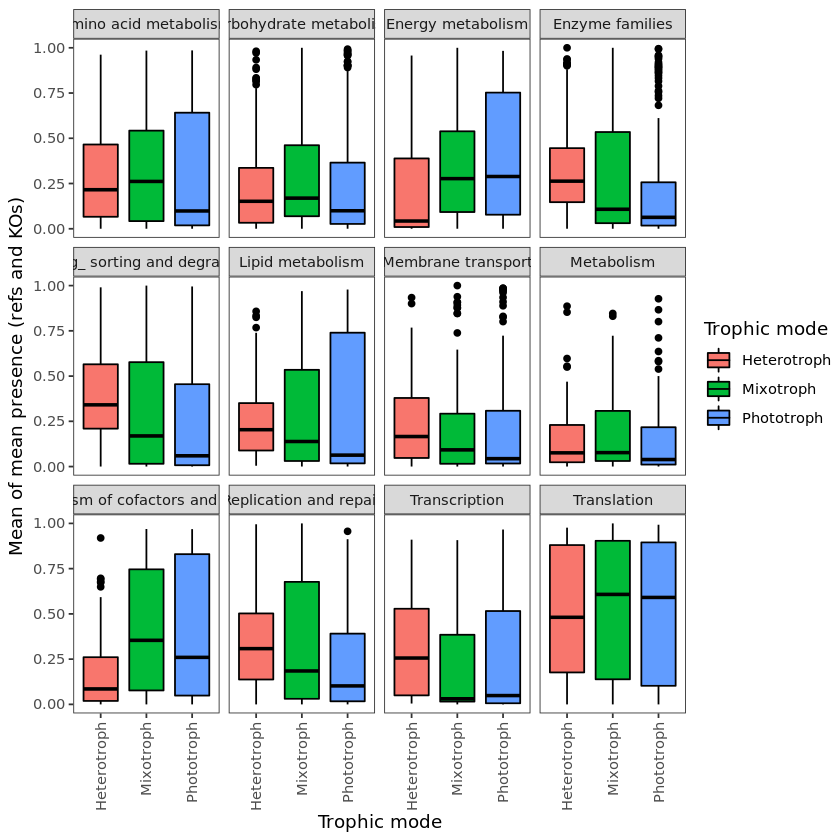

In [24]:
scores_with_KOs = training_scores %>% dplyr::left_join(ko_info_vita, by = c("KEGG_ID_NUM" = "IDnum"))
mean_frame = ko_info_vita %>% dplyr::group_by(class) %>% dplyr::tally() %>%
  mutate(class = fct_reorder(class, desc(n))) %>% dplyr::filter(n>50)

tm_kos = scores_with_KOs %>% dplyr::group_by(Predicted.trophic.mode,class) %>%
    dplyr::filter(class %in% mean_frame$class)
ggplot(tm_kos) + geom_boxplot(aes(x = Predicted.trophic.mode, y = Ratio, fill = Predicted.trophic.mode), 
                              #(x = class, y = Ratio, fill = Predicted.trophic.mode),
                           col="black") +
    theme_test() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    facet_wrap(~class) + 
    scale_fill_discrete(name = "Trophic mode") + 
    xlab("Trophic mode") + ylab("Mean of mean presence (refs and KOs)")

`summarise()` has grouped output by 'Predicted.trophic.mode', 'KEGG_ID_NUM'. You can override using the `.groups` argument.



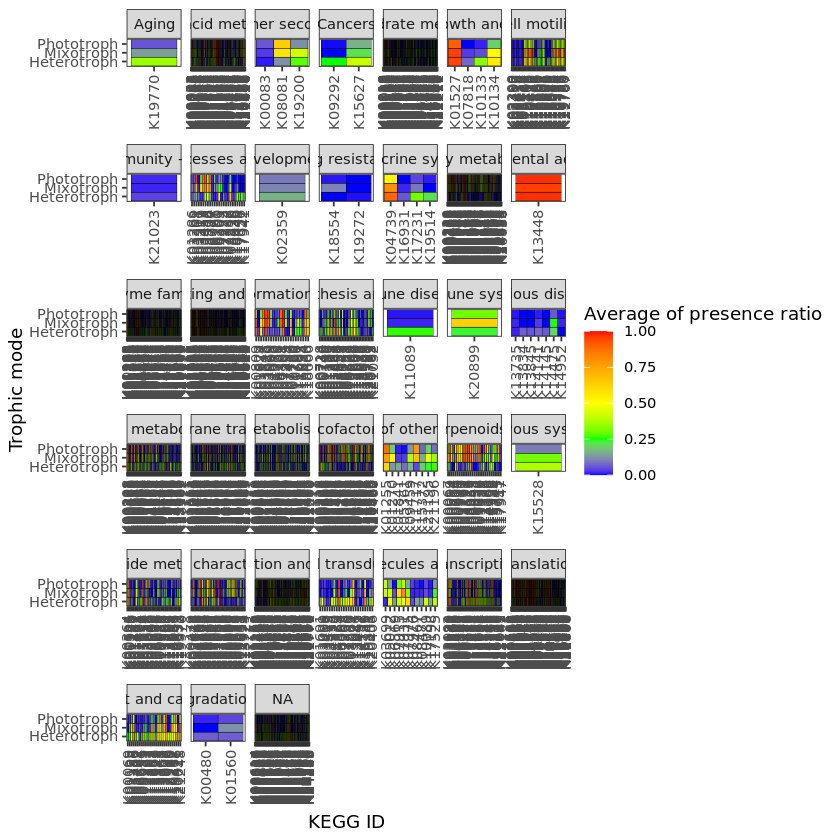

In [25]:
scores_with_KOs = training_scores %>% dplyr::left_join(ko_info_vita, by = c("KEGG_ID_NUM" = "IDnum"))
tm_kos = scores_with_KOs %>% dplyr::group_by(Predicted.trophic.mode,KEGG_ID_NUM,class) %>% 
            dplyr::summarize(MeanRatio = mean(Ratio))
ggplot(tm_kos) + geom_tile(aes(x = KEGG_ID_NUM, y = Predicted.trophic.mode, fill = MeanRatio),
                           col="black") + scale_fill_gradientn(colors=c("blue","green",
                                                                       "yellow","orange","red"),
                                                              name = "Average of presence ratio") +
    theme_test() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    facet_wrap(~class, scales = "free_x") + 
    xlab("KEGG ID") + ylab("Trophic mode")
ggsave("presence_ratio_facetted.png",width=25,height=8,units="in")

`summarise()` has grouped output by 'Predicted.trophic.mode', 'KEGG_ID_NUM'. You can override using the `.groups` argument.



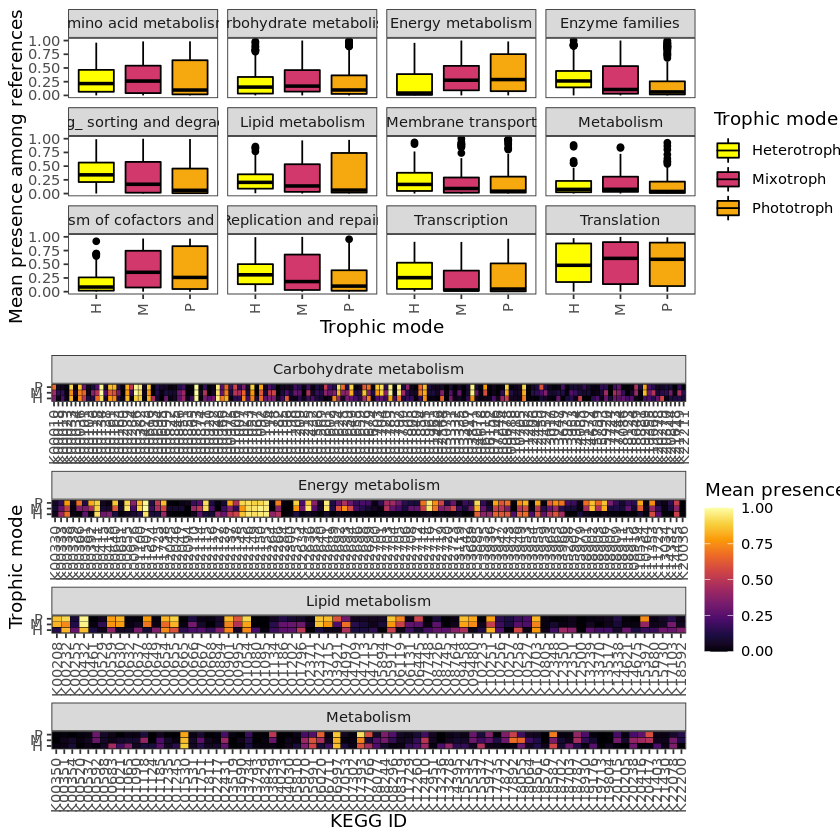

In [12]:
# create composite plot 
scores_with_KOs = training_scores %>% dplyr::left_join(ko_info_vita, by = c("KEGG_ID_NUM" = "IDnum"))
tm_kos = scores_with_KOs %>% dplyr::group_by(Predicted.trophic.mode,KEGG_ID_NUM,class) %>% 
            dplyr::summarize(MeanRatio = mean(Ratio)) %>% dplyr::filter(class %in% 
                                                                       c("Carbohydrate metabolism",
                                                                         "Energy metabolism",
                                                                         "Lipid metabolism",
                                                                         "Metabolism"))
heatmap = ggplot(tm_kos) + geom_tile(aes(x = KEGG_ID_NUM, y = Predicted.trophic.mode, fill = MeanRatio),
                           col="black") + 
    #scale_fill_viridis(name = "Mean presence") +
    #scale_fill_gradientn(colors=c("#F6A90F","#4A9C30","#522376"),name = "Mean presence") + 
    scale_fill_gradientn(colors=inferno(10),name = "Mean presence") + 

    theme_test() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    scale_y_discrete(breaks=c("Phototroph","Mixotroph","Heterotroph"),labels=c("P","M","H"))+
    facet_wrap(~class, scales = "free_x",ncol = 1) + 
    xlab("KEGG ID") + ylab("Trophic mode")
#ggsave("presence_ratio_facetted.png",width=25,height=8,units="in")

scores_with_KOs = training_scores %>% dplyr::left_join(ko_info_vita, by = c("KEGG_ID_NUM" = "IDnum"))
mean_frame = ko_info_vita %>% dplyr::group_by(class) %>% dplyr::tally() %>%
  mutate(class = fct_reorder(class, desc(n))) %>% dplyr::filter(n>50)

tm_kos = scores_with_KOs %>% dplyr::group_by(Predicted.trophic.mode,class) %>%
    dplyr::filter(class %in% mean_frame$class)
boxplot = ggplot(tm_kos) + geom_boxplot(aes(x = Predicted.trophic.mode, y = Ratio, fill = Predicted.trophic.mode), 
                              #(x = class, y = Ratio, fill = Predicted.trophic.mode),
                           col="black") +
    theme_test() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    facet_wrap(~class) + 
    scale_fill_manual(name = "Trophic mode",values=c("yellow","#d2386b","#F6A90F")) + #("#F6A90F","#522376","#4A9C30")) + 
    scale_x_discrete(breaks=c("Phototroph","Mixotroph","Heterotroph"),labels=c("P","M","H"))+
    xlab("Trophic mode") + ylab("Mean presence among references")

cowplot::plot_grid(boxplot,heatmap,ncol=1,rel_heights=c(0.7,1))
ggsave(file.path("..","si-figures","KO_figure_trophy.png"),width=16,height=10,units="in",dpi=400)

In [28]:
##### OBTAIN TRAINING METRICS #####
# Heterotrophy index model
training_scores = generate_scores_selected_features(train_rows, vita$var)

# filter training data to selected vars
train_filt <- (train_rows %>% dplyr::select(starts_with("K") & !starts_with("Ke")))[ , vita$var]
# Make an mlr task with the ibd_train dataset here 
tmp <- train_filt
tmp$trophic_train <- train_rows$Trophic.mode
colnames(tmp) <-  make.names(colnames(tmp))
task <- makeClassifTask(data = tmp, target = "trophic_train")
# Run tuning process
task_res <- tuneRanger(task, num.threads = 2)
recommended_pars <- task_res$recommended.pars

# write model parameters to a file
write_tsv(task_res$recommended.pars, file.path("..","data",
                                               paste0("recommended_pars_seed1",as.character(Sys.Date()),
                                                      "_rand.txt")))

`summarise()` has grouped output by 'Trophic.mode'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Trophic.mode'. You can override using the `.groups` argument.

Computing y column(s) for design. Not provided.

[mbo] 0: mtry=1049; min.node.size=37; sample.fraction=0.53 : y = 0.123 : 5.2 secs : initdesign

[mbo] 0: mtry=1456; min.node.size=3; sample.fraction=0.727 : y = 0.0925 : 11.2 secs : initdesign

[mbo] 0: mtry=954; min.node.size=4; sample.fraction=0.301 : y = 0.111 : 3.1 secs : initdesign

[mbo] 0: mtry=1277; min.node.size=53; sample.fraction=0.763 : y = 0.127 : 8.9 secs : initdesign

[mbo] 0: mtry=507; min.node.size=10; sample.fraction=0.393 : y = 0.11 : 2.2 secs : initdesign

[mbo] 0: mtry=160; min.node.size=5; sample.fraction=0.325 : y = 0.113 : 0.8 secs : initdesign

[mbo] 0: mtry=1531; min.node.size=3; sample.fraction=0.686 : y = 0.0942 : 11.2 secs : initdesign

[mbo] 0: mtry=762; min.node.size=11; sample.fraction=0.848 : y = 0.0928 : 6.9

[mbo] 54: mtry=220; min.node.size=2; sample.fraction=0.856 : y = 0.0823 : 2.4 secs : infill_cb

[mbo] 55: mtry=269; min.node.size=2; sample.fraction=0.875 : y = 0.079 : 3.0 secs : infill_cb

[mbo] 56: mtry=239; min.node.size=2; sample.fraction=0.881 : y = 0.0808 : 2.6 secs : infill_cb

[mbo] 57: mtry=217; min.node.size=2; sample.fraction=0.846 : y = 0.0808 : 2.4 secs : infill_cb

[mbo] 58: mtry=212; min.node.size=2; sample.fraction=0.867 : y = 0.0809 : 2.4 secs : infill_cb

[mbo] 59: mtry=214; min.node.size=2; sample.fraction=0.878 : y = 0.0831 : 2.5 secs : infill_cb

[mbo] 60: mtry=201; min.node.size=2; sample.fraction=0.871 : y = 0.082 : 2.3 secs : infill_cb

[mbo] 61: mtry=235; min.node.size=2; sample.fraction=0.869 : y = 0.0821 : 2.6 secs : infill_cb

[mbo] 62: mtry=210; min.node.size=2; sample.fraction=0.886 : y = 0.0805 : 2.5 secs : infill_cb

[mbo] 63: mtry=206; min.node.size=2; sample.fraction=0.881 : y = 0.0819 : 2.4 secs : infill_cb

[mbo] 64: mtry=201; min.node.size=2; sampl

In [9]:
recommended_pars = read_tsv(file.path("..","data",
                   paste0("recommended_pars_seed12021-04-25_rand.txt")))


── Column specification ────────────────────────────────────────────────────────────────────────────
cols(
  mtry = col_double(),
  min.node.size = col_double(),
  sample.fraction = col_double(),
  multiclass.brier = col_double(),
  exec.time = col_double()
)




In [10]:
##### CALCULATE HETEROTROPHY INDEX SCORES #####
training_scores = generate_scores_selected_features(train_rows, vita$var)
listed_outputs = classify_points_binom(test_rows, training_scores, "Source_ID")
score_matrix = listed_outputs[[1]]
predicted_by_heterotrophyindex = listed_outputs[[2]]
predicted_by_maxscore = listed_outputs[[3]]

`summarise()` has grouped output by 'Trophic.mode'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Trophic.mode'. You can override using the `.groups` argument.



In [13]:
write.csv(training_scores,file.path("/vortexfs1","omics","alexander","share","kegg_training_scores.csv"))

             predicted
observed      Heterotroph Mixotroph Phototroph
  Heterotroph         211         0          0
  Mixotroph             0        65          0
  Phototroph            0         0        412
[1] "ACCURACY = 1"


Warning message:
“package ‘scales’ was built under R version 3.6.3”

Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




             predicted
observed      Heterotroph Mixotroph Phototroph
  Heterotroph          67         0          1
  Mixotroph             1        13          7
  Phototroph            3         0        132
[1] "ACCURACY = 0.946428571428571"


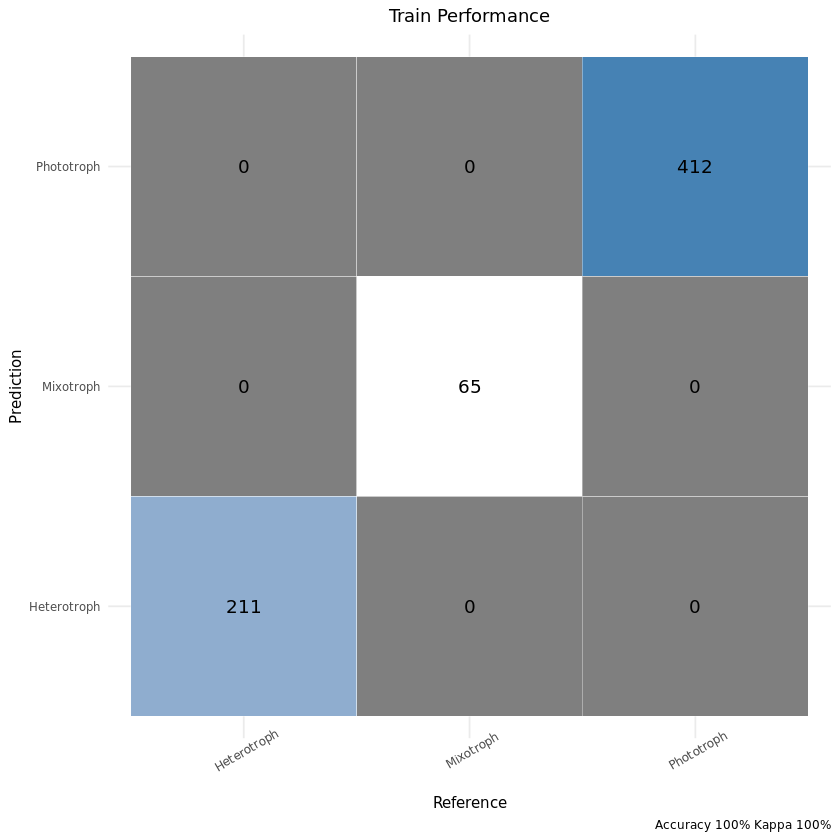

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  X1 = col_character()
)
ℹ Use `spec()` for the full column specifications.





Heterotroph   Mixotroph  Phototroph 
        709           0         286 

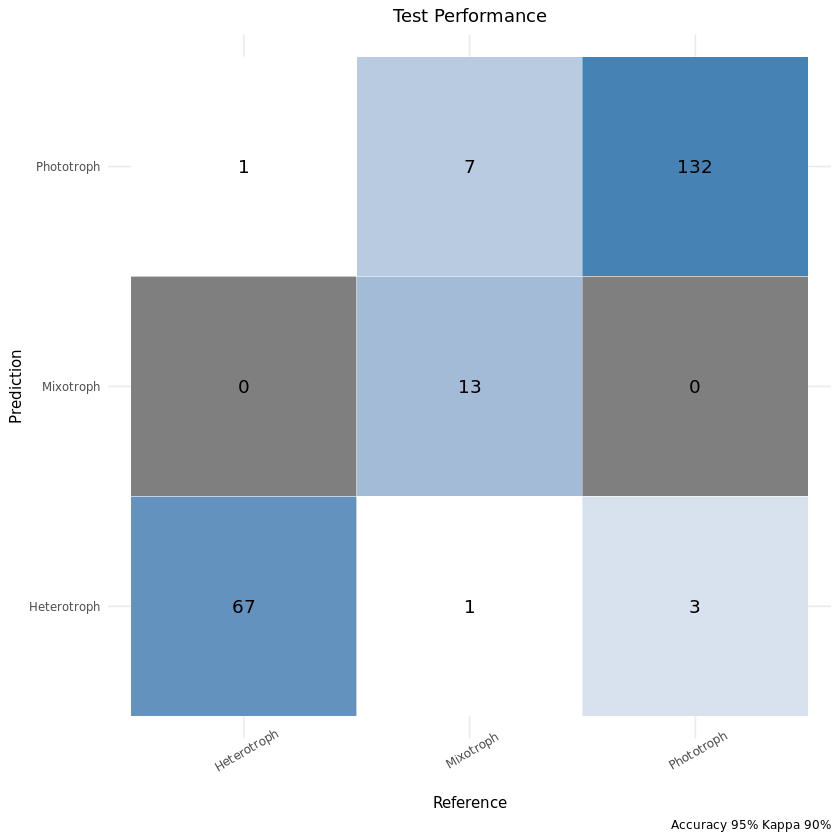

In [11]:
##### EVALUATE RF MODEL ON TEST DATA #####

# extract model parameters and use to build an optimal RF

# use model parameters to build optimized RF
train_filt <- (train_rows %>% dplyr::select(starts_with("K") & !starts_with("Ke")))[ , vita$var]
train_filt$trophic <- as.factor(train_rows$Trophic.mode)
optimal_rf <- ranger(
  dependent.variable.name = "trophic",
  mtry            = recommended_pars$mtry,
  num.trees       = 10000,
  data            = train_filt,
  sample.fraction = recommended_pars$sample.fraction,
  min.node.size   = recommended_pars$min.node.size,
  seed            = 1,
  importance      = 'impurity'
)

saveRDS(optimal_rf, file = file.path("..","data",
                                     paste0("optimal_rf_seed1_",as.character(Sys.Date()),
                                            "_rand.RDS")))

evaluate_model(optimal_ranger = optimal_rf,
               data = train_filt, reference_class = as.factor(train_filt$trophic),
               plt_title = "Train Performance")

##### EVALUATE MODEL ON UNKNOWN MAGS #####
test_rows = test_rows %>% arrange(Source_ID)
test_filt <- (test_rows %>% dplyr::select(starts_with("K") & !starts_with("Ke")))[ , vita$var]
test_filt$trophic <- test_rows$Trophic.mode

evaluate_model(optimal_ranger = optimal_rf,
               data = test_filt, reference_class = as.factor(test_filt$trophic),
               plt_title = "Test Performance")

# run the model to predict trophic level of unknown mags ------------------
mags_unknown <- read_csv(file.path("..","data","MAG_keggannot.csv"))

mags_unknown <- mags_unknown %>%
  select(X1, all_of(vita$var)) %>%
  as.data.frame() %>%
  column_to_rownames("X1")

pred <- predict(optimal_rf, mags_unknown)
table(pred$predictions)

In [15]:
burns_combined = predicted_by_heterotrophyindex %>% 


ERROR: Error in parse(text = x, srcfile = src): <text>:3:0: unexpected end of input
1: burns_combined = predicted_by_heterotrophyindex %>% 
2: 
  ^


**Look at the output of the Burns model in the context of all the output from the MMETSP**

In [12]:
##### CALCULATE HETEROTROPHY INDEX SCORES #####
training_scores = generate_scores_selected_features(train_rows, vita$var)
listed_outputs = classify_points_binom(mmetsp_allfeatures_test, training_scores, "Source_ID")
score_matrix = listed_outputs[[1]]
predicted_by_heterotrophyindex = listed_outputs[[2]]
predicted_by_maxscore = listed_outputs[[3]]

`summarise()` has grouped output by 'Trophic.mode'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Trophic.mode'. You can override using the `.groups` argument.



In [13]:
##### READ IN BURNS MODEL OUTPUT FROM THE MMETSP #####
burns_mmetsp = data.frame(fread(file.path("..","data","burns_model_MMETSP.txt"),sep="\t"))

In [14]:
burns_mmetsp["MMETSP_ID"] = sapply(strsplit(as.character(burns_mmetsp$Genome),"\\."), `[`, 1)

In [15]:
mmetsp_validation = mmetsp_allfeatures_test
mmetsp_validation$RF.predicted.TM = predict(optimal_rf, mmetsp_allfeatures_test)$predictions
burns_combined = predicted_by_heterotrophyindex %>% 
    dplyr::right_join(burns_mmetsp, by=c("Source_ID"="MMETSP_ID")) %>% 
    dplyr::left_join(mmetsp_validation %>% dplyr::select(Source_ID, Trophic.mode, RF.predicted.TM)) %>%
    dplyr::filter(!is.na(Trophic.mode))

Joining, by = "Source_ID"



In [16]:
head(burns_combined)

Source_ID,HeterotrophyScore,Predicted.trophic.mode,Genome,Phagocyte.generalist.prediction,Phagocyte.entamoebid.prediction,Phagocyte.rozellid.prediction,Prototrophy.prediction,Photosynthesis.prediction,Trophic.mode,RF.predicted.TM
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
MMETSP0004,-171,Phototroph,MMETSP0004.sigModels.txt,0.889731115,0.528433609,0.52287997,0.8174219,0.6225132,Mixotroph,Mixotroph
MMETSP0005,-191,Phototroph,MMETSP0005.sigModels.txt,0.878768860,0.583442183,0.55591812,0.8401780,0.7197547,Mixotroph,Mixotroph
MMETSP0006,-213,Phototroph,MMETSP0006.sigModels.txt,0.984406674,0.918754111,0.98484050,0.9436317,0.8267831,Mixotroph,Mixotroph
MMETSP0007,-118,Phototroph,MMETSP0007.sigModels.txt,0.035348350,0.012328994,0.79060198,0.2651389,0.4062242,Mixotroph,Phototroph
MMETSP0008,-207,Phototroph,MMETSP0008.sigModels.txt,0.990317076,0.804827673,0.97790264,0.9647772,0.9226580,Mixotroph,Mixotroph
MMETSP0009,-364,Phototroph,MMETSP0009.sigModels.txt,0.003764949,0.007255985,0.06845157,0.9122915,0.9242969,Phototroph,Phototroph


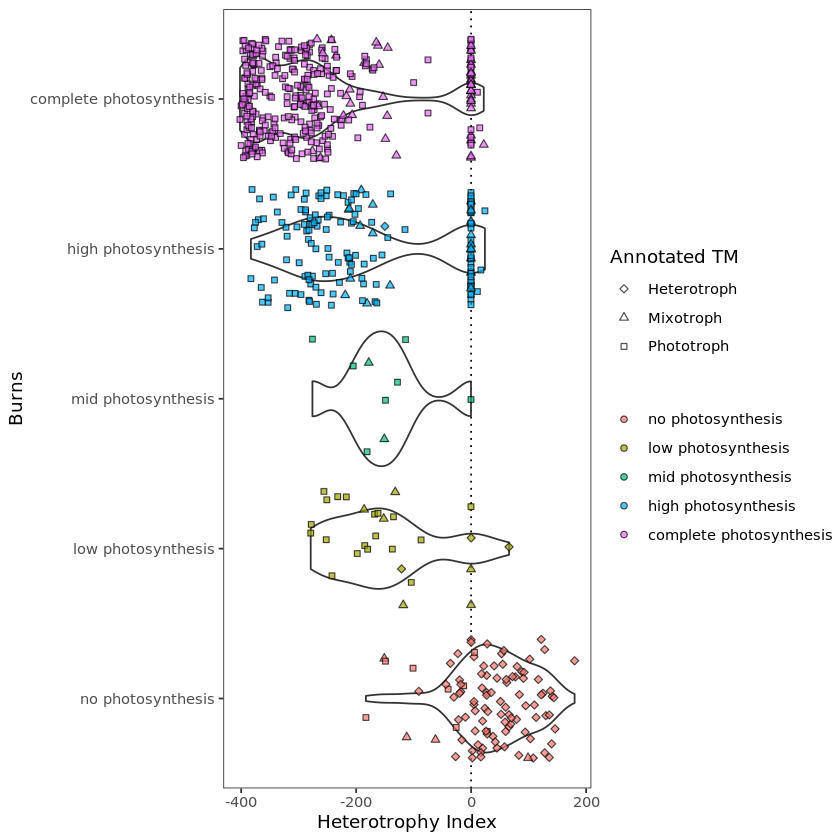

In [63]:
ggplot(burns_combined %>% dplyr::mutate(PhotosynCategory=cut(Photosynthesis.prediction, 
                                                             breaks=c(0,0.1,0.45,0.55,0.9,1.1), 
                                                             labels=c("no photosynthesis",
                                                                      "low photosynthesis",
                                                                      "mid photosynthesis",
                                                                      "high photosynthesis",
                                                                      "complete photosynthesis")))) + 
    geom_vline(aes(xintercept=0),linetype="dotted") + 
    geom_violin(aes(x = HeterotrophyScore, y= PhotosynCategory),fill="white") + 
    scale_fill_discrete(name="") + scale_shape_manual(name="Annotated TM",values=c(23,24,22)) +
    geom_jitter(aes(x = HeterotrophyScore, y= PhotosynCategory,fill=PhotosynCategory,
                    shape = Trophic.mode),color="black",alpha=0.7,size=1.5) + 
    theme_test() + ylab("Burns") + 
    guides(fill=guide_legend(override.aes = list(shape=21))) + xlab("Heterotrophy Index")
ggsave(file.path("..","si-figures","burns_categories.png"),dpi=350,width=8,height=6,units="in")

In [21]:
burns_combined %>% dplyr::mutate(PhotosynCategory=cut(Photosynthesis.prediction, 
                                                             breaks=c(0,0.1,0.45,0.55,0.9,1.1), 
                                                             labels=c("no photosynthesis",
                                                                      "low photosynthesis",
                                                                      "mid photosynthesis",
                                                                      "high photosynthesis",
                                                                      "complete photosynthesis"))) %>%
    dplyr::group_by(PhotosynCategory) %>% dplyr::summarize(MeanHeterotrophyIndex = mean(HeterotrophyScore),
                                                         StdHeterotrophyIndex = sd(HeterotrophyScore))

PhotosynCategory,MeanHeterotrophyIndex,StdHeterotrophyIndex
<fct>,<dbl>,<dbl>
no photosynthesis,38.85304,68.18859
low photosynthesis,-149.01762,93.52066
mid photosynthesis,-153.58329,74.78102
high photosynthesis,-184.27744,128.16011
complete photosynthesis,-272.33771,119.93957


In [22]:
predict(optimal_rf, mmetsp_allfeatures_test)

Ranger prediction

Type:                             Classification 
Sample size:                      642 
Number of independent variables:  1787 

In [48]:
nrow(burns_combined %>% dplyr::filter(RF.predicted.TM != Trophic.mode) %>% 
    dplyr::select(HeterotrophyScore,Predicted.trophic.mode,RF.predicted.TM,
                  Photosynthesis.prediction,Trophic.mode))
nrow(burns_combined)

Adding missing grouping variables: `Source_ID`



[1] 7

[1] 642

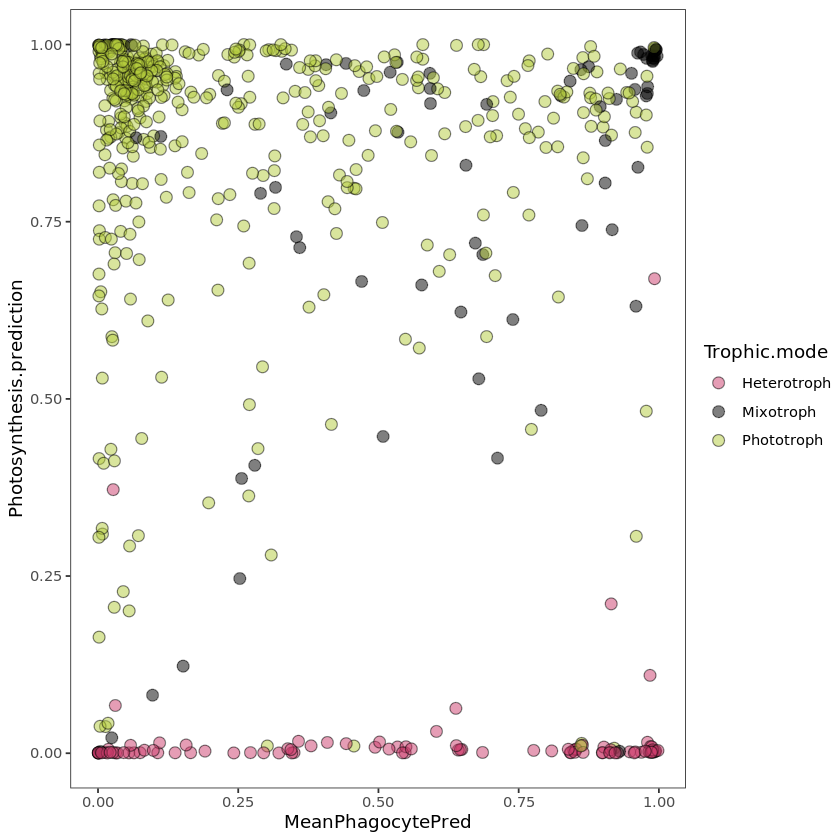

In [49]:
burns_combined = burns_combined %>% dplyr::mutate("MeanPhagocytePred" = (Phagocyte.generalist.prediction + 
                                 Phagocyte.entamoebid.prediction +
                                 Phagocyte.rozellid.prediction) / 3)
ggplot(burns_combined) + geom_point(aes(x=MeanPhagocytePred,
                                        y=Photosynthesis.prediction,fill = Trophic.mode),pch=21,col="black",
                                   size=3,alpha=0.5) + 
    scale_fill_manual(values=c("#CC3D6D","black","#B4CC3D"),breaks=c("Heterotroph","Mixotroph","Phototroph")) + 
    theme_test()

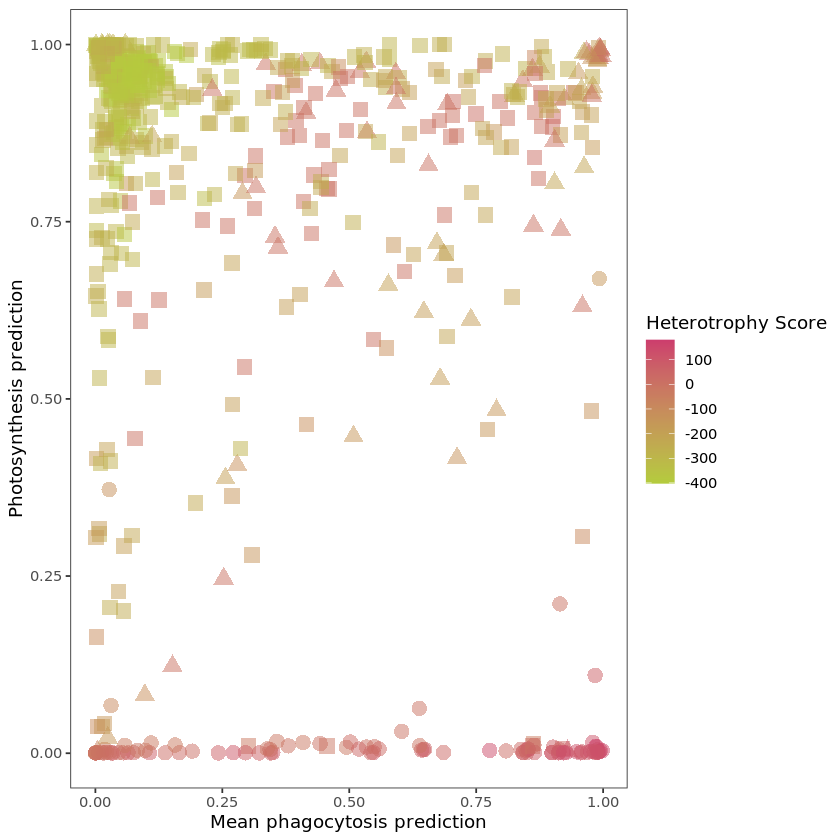

In [122]:
burns_plot1 = ggplot(burns_combined) + geom_point(aes(x=MeanPhagocytePred,
                                        y=Photosynthesis.prediction,shape = Trophic.mode,
                                        col=HeterotrophyScore),
                                   size=4,alpha=0.5) + 
    #scale_color_viridis(name="Heterotrophy Score") + 
    scale_color_gradient(high="#CC3D6D",low="#B4CC3D",name="Heterotrophy Score") +
    guides(shape=FALSE) + 
    ylab("Photosynthesis prediction") + xlab("Mean phagocytosis prediction") +
    theme_test()
burns_plot1

In [18]:
burns_combined = burns_combined %>% mutate(PhagoBin = cut(MeanPhagocytePred, breaks = c(0,0.25,0.5,0.75,1)),
                          PhotoBin = cut(Photosynthesis.prediction, breaks = c(0,0.25,0.5,0.75,1)),
                                         PhagoGeneralBin = cut(Phagocyte.generalist.prediction, breaks = c(0,0.25,0.5,0.75,1)))
combined_metrics = burns_combined %>% dplyr::select(MeanPhagocytePred,Photosynthesis.prediction,
                                                    Prototrophy.prediction,Trophic.mode,Source_ID,
                                                    Phagocyte.generalist.prediction) %>% 
                    reshape2::melt(id.vars=c("Trophic.mode","Source_ID")) 

ERROR: Error: Problem with `mutate()` input `PhagoBin`.
[31m✖[39m object 'MeanPhagocytePred' not found
[34mℹ[39m Input `PhagoBin` is `cut(MeanPhagocytePred, breaks = c(0, 0.25, 0.5, 0.75, 1))`.
[34mℹ[39m The error occurred in group 1: Source_ID = "MMETSP0004".


In [225]:
burns_combined_tax %>% dplyr::filter(groups == "Eukaryota")

Source_ID,HeterotrophyScore,Predicted.trophic.mode,Genome,Phagocyte.generalist.prediction,Phagocyte.entamoebid.prediction,Phagocyte.rozellid.prediction,Prototrophy.prediction,Photosynthesis.prediction,Trophic.mode,⋯,MeanPhagocytePred,PhagoBin,PhotoBin,PhagoGeneralBin,Domain,Supergroup,Class,Division,groups,groups_full
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,⋯,<dbl>,<fct>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
MMETSP0011,-306.0000000,Phototroph,MMETSP0011.sigModels.txt,6.060759e-04,0.0018099645,0.005027436,0.8216449782,0.7373424266,Phototroph,⋯,0.002481159,"(0,0.25]","(0.5,0.75]","(0,0.25]",NA,Archaeplastida,Stylonematophyceae,Rhodophyta,Eukaryota,Rhodophyta;Archaeplastida
MMETSP0039,-167.0000000,Phototroph,MMETSP0039.sigModels.txt,3.167348e-02,0.0925700649,0.517167403,0.5167319211,0.6534230054,Phototroph,⋯,0.213803649,"(0,0.25]","(0.5,0.75]","(0,0.25]",NA,Excavata,Euglenozoa,Discoba,Eukaryota,Discoba;Excavata
MMETSP0040,-0.1293930,Mixotroph,MMETSP0040.sigModels.txt,9.955668e-01,0.9562452631,0.949992056,0.9495638552,0.9894847676,Mixotroph,⋯,0.967268034,"(0.75,1]","(0.75,1]","(0.75,1]",NA,Rhizaria,Chlorarachniophyceae,Cercozoa,Eukaryota,Cercozoa;Rhizaria
MMETSP0041,-146.0000000,Phototroph,MMETSP0041.sigModels.txt,9.978327e-01,0.9944598586,0.974584876,0.8617599184,0.9760729435,Mixotroph,⋯,0.988959153,"(0.75,1]","(0.75,1]","(0.75,1]",NA,Rhizaria,Chlorarachniophyceae,Cercozoa,Eukaryota,Cercozoa;Rhizaria
MMETSP0042,-153.0000000,Phototroph,MMETSP0042.sigModels.txt,9.996655e-01,0.9825032819,0.979435620,0.8870334818,0.9843535726,Mixotroph,⋯,0.987201483,"(0.75,1]","(0.75,1]","(0.75,1]",NA,Rhizaria,Chlorarachniophyceae,Cercozoa,Eukaryota,Cercozoa;Rhizaria
MMETSP0045,-0.1777457,Mixotroph,MMETSP0045.sigModels.txt,9.998676e-01,0.9954065305,0.980540461,0.9270761856,0.9802869059,Mixotroph,⋯,0.991938208,"(0.75,1]","(0.75,1]","(0.75,1]",NA,Rhizaria,Chlorarachniophyceae,Cercozoa,Eukaryota,Cercozoa;Rhizaria
MMETSP0086,80.0000000,Heterotroph,MMETSP0086.sigModels.txt,9.009465e-01,0.7285404860,0.896748130,0.0340670262,0.0009735811,Heterotroph,⋯,0.842078381,"(0.75,1]","(0,0.25]","(0.75,1]",NA,Rhizaria,Thecofilosea,Cercozoa,Eukaryota,Cercozoa;Rhizaria
MMETSP0087,130.0000000,Heterotroph,MMETSP0087.sigModels.txt,9.999336e-01,0.9992897090,0.983690752,0.8891713970,0.0033553948,Heterotroph,⋯,0.994304678,"(0.75,1]","(0,0.25]","(0.75,1]",NA,Rhizaria,Thecofilosea,Cercozoa,Eukaryota,Cercozoa;Rhizaria
MMETSP0105,113.0000000,Heterotroph,MMETSP0105.sigModels.txt,9.994597e-01,0.9981534534,0.941320301,0.5901233814,0.0154234711,Heterotroph,⋯,0.979644491,"(0.75,1]","(0,0.25]","(0.75,1]",NA,Opisthokonta,Choanoflagellatea,Choanoflagellida,Eukaryota,Choanoflagellida;Opisthokonta


In [ ]:
burns_combined_tax = burns_combined %>% 
    dplyr::left_join(all_tax_info %>% 
                     dplyr::select(Domain,Supergroup,Class,Division,Source_ID))%>% 
    dplyr::mutate(groups=paste(Division,Supergroup,sep=";")) %>%
                        dplyr::mutate(groups_full = as.character(groups)) %>%
                        dplyr::mutate(groups = case_when(grepl("Fungi",groups_full) ~ "Fungi",
                                                         grepl("Metazoa",groups_full) ~ "Metazoa",
                                                         grepl("Chlorophyta",groups_full) ~ "Chlorophyta",
                                                         grepl("Cryptophyta",groups_full) ~ "Cryptophyta",
                                                         grepl("Haptophyta",groups_full) ~ "Haptophyta",
                                                         grepl("Ochrophyta",groups_full) ~ "Ochrophyta",
                                                         grepl("Alveolata",groups_full) ~ "Sar",
                                                         grepl("Rhizaria",groups_full) ~ "Sar",
                                                         grepl("Stramenopiles",groups_full) ~ "Sar",
                                                         (groups_full == "Alveolata;Ciliophora") ~ "Sar",
                                                         (groups_full == "Alveolata;Dinoflagellata") ~ "Sar",
                                                         (groups_full == "Stramenopiles;-") ~ "Sar",
                                                         (groups_full == "Stramenopiles;") ~ "Sar",
                                                          grepl("Amoebozoa",groups_full)  ~ "Amoebozoa",
                                                         (groups_full == "-;") ~ "Eukaryota",
                                                         (groups_full == "-;-") ~ "Eukaryota",
                                                         (groups_full == ";-") ~ "Eukaryota",
                                                         grepl("Opisthokonta",groups_full) ~ "Opisthokonta",
                                                         TRUE ~ "Eukaryota"))

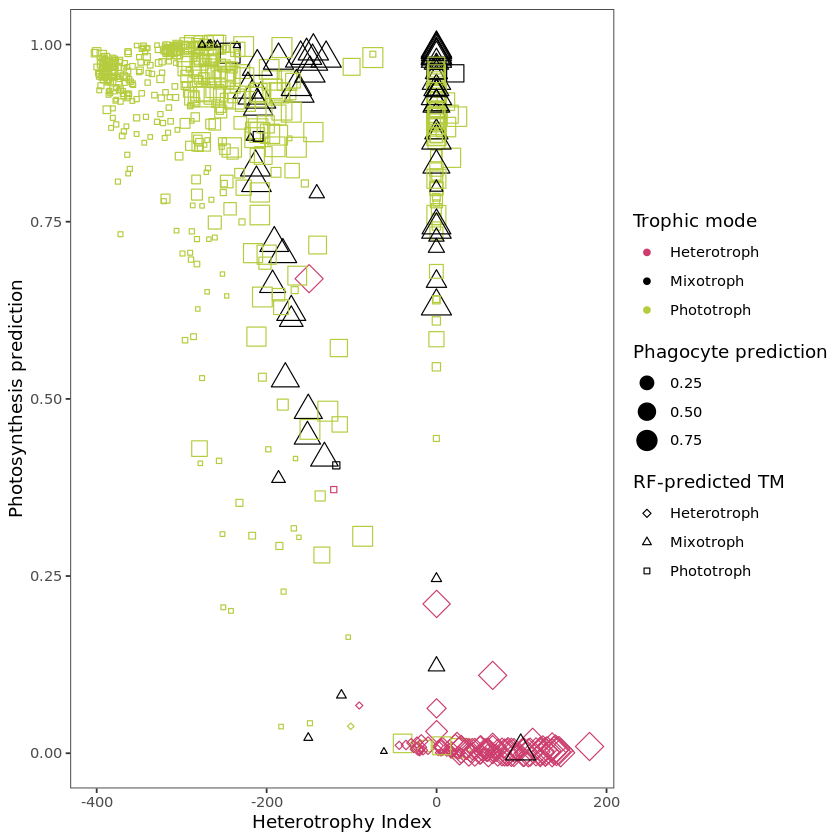

In [227]:
burnsplot_2 = ggplot(burns_combined) + geom_point(aes(y=Photosynthesis.prediction,
                                        x=HeterotrophyScore,color=Trophic.mode,
                                        shape=RF.predicted.TM,size=Phagocyte.generalist.prediction)) +
    #scale_shape_manual(values=c(1,2,3),"ML trophic mode") + 
    scale_shape_manual(name="RF-predicted TM", values = c(23,24,22),
                       breaks=c("Heterotroph","Mixotroph","Phototroph"),drop=FALSE) +  
    scale_size(name="Phagocyte prediction") + xlab("Heterotrophy Index") + 
    ylab("Photosynthesis prediction") + 
    scale_color_manual(values=c("#CC3D6D","black","#B4CC3D"),
                       breaks=c("Heterotroph","Mixotroph","Phototroph"),
                       name = "Trophic mode") + 
    theme_test()
burnsplot_2

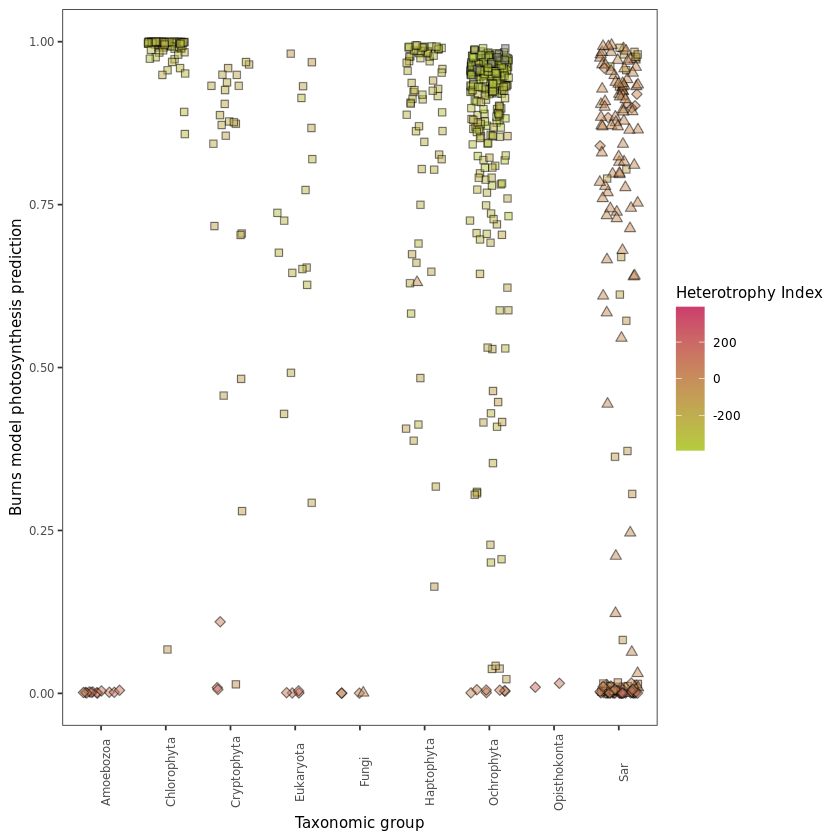

In [245]:
mmetsp_tax = ggplot(burns_combined_tax) + #geom_point(aes(x=groups,y=HeterotrophyScore)) + 
    geom_jitter(aes(x = groups, y = Photosynthesis.prediction,
                                            fill = HeterotrophyScore,
                                            shape = Predicted.trophic.mode),
                                          width=0.3, size=2, alpha=0.5) + theme_test() + 
    scale_shape_manual(name="RF-predicted TM", values = c(23,22,24),breaks=c("Heterotroph","Phototroph","Mixotroph")) +  
    #scale_fill_distiller(type = "div", limit = limit, low="#B4CC3D", high="#CC3D6D") + 
    scale_fill_gradient(limits=limit, low="#B4CC3D", high="#CC3D6D", name="Heterotrophy Index") + 
    guides(shape=FALSE) +
    theme(text = element_text(size = 9),
          axis.text.x = element_text(angle = 90, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5)) + xlab("Taxonomic group") + 
    ylab("Burns model photosynthesis prediction")
mmetsp_tax

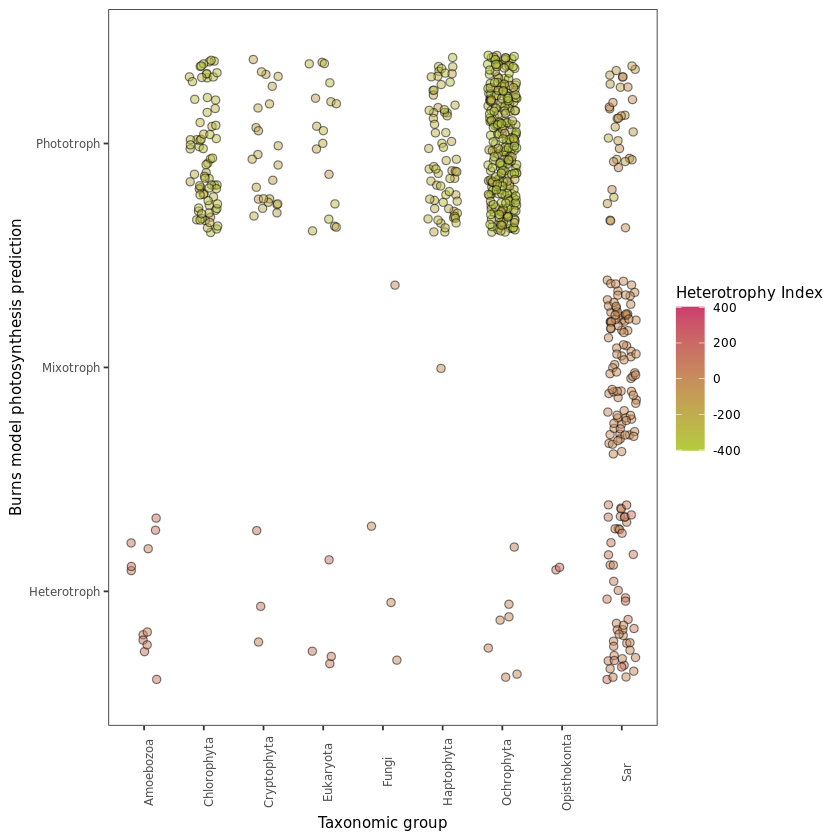

In [31]:
limit <- max(abs(burns_combined_tax$HeterotrophyScore)) * c(-1, 1)

mmetsp_tax = ggplot(burns_combined_tax) + #geom_point(aes(x=groups,y=HeterotrophyScore)) + 
    geom_jitter(aes(x = groups, y = Predicted.trophic.mode,
                                            fill = HeterotrophyScore),
                                          width=0.25, size=2, alpha=0.5,pch=21) + theme_test() + 
    #scale_shape_manual(name="RF-predicted TM", values = c(23,22,24),breaks=c("Heterotroph","Phototroph","Mixotroph")) +  
    #scale_fill_distiller(type = "div", limit = limit, low="#B4CC3D", high="#CC3D6D") + 
    scale_fill_gradient(limits=limit, low="#B4CC3D", high="#CC3D6D", name="Heterotrophy Index") + 
    theme(text = element_text(size = 9),
          axis.text.x = element_text(angle = 90, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5)) + xlab("Taxonomic group") + 
    ylab("Random Forest model photosynthesis prediction")
mmetsp_tax

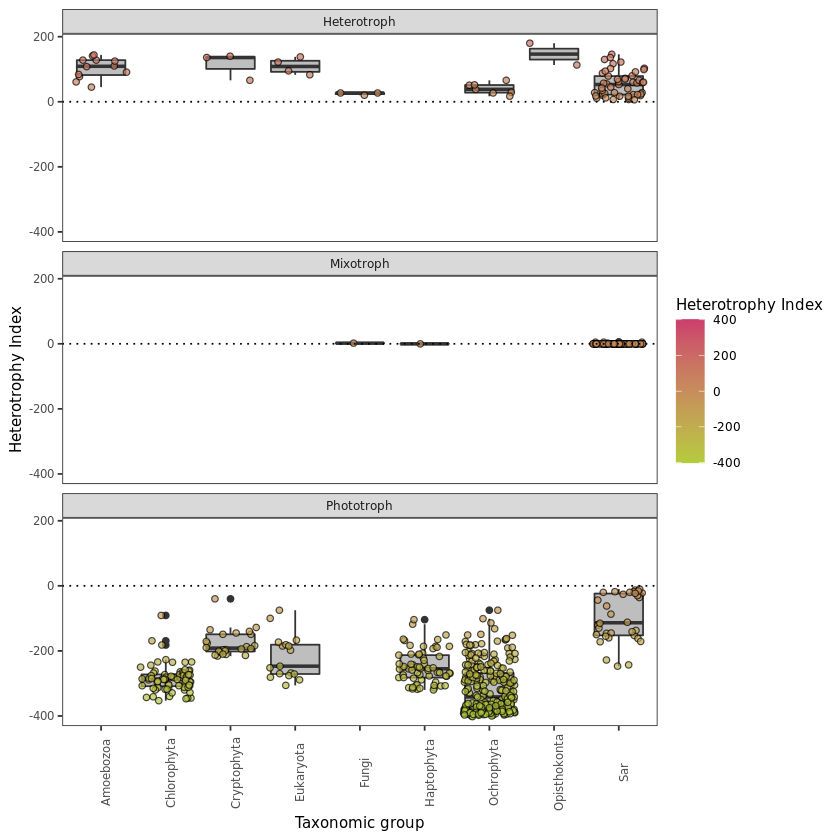

In [23]:
limit <- max(abs(burns_combined_tax$HeterotrophyScore)) * c(-1, 1)

mmetsp_tax = ggplot(burns_combined_tax) + #geom_point(aes(x=groups,y=HeterotrophyScore)) + 
    geom_boxplot(aes(x = groups, y = HeterotrophyScore),fill="gray") +
    geom_jitter(aes(x = groups, y = HeterotrophyScore,fill=HeterotrophyScore),alpha=0.7,pch=21) + theme_test() +
    geom_hline(aes(yintercept=0),linetype="dotted")+
    facet_wrap(~Predicted.trophic.mode,ncol=1) +
    scale_fill_gradient(limits=limit, low="#B4CC3D", high="#CC3D6D", name="Heterotrophy Index") + 
    theme(text = element_text(size = 9),
          axis.text.x = element_text(angle = 90, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5)) + xlab("Taxonomic group") + 
    ylab("Heterotrophy Index")
mmetsp_tax
ggsave(file="heterotrophy_index_mmetsp.png", width=5,height=8,units="in",dpi=300)

In [19]:
cowplot::plot_grid(cowplot::plot_grid(burnsplot_2 + theme(legend.position="none") + 
    geom_vline(aes(xintercept=0),linetype="dotted") + 
    geom_hline(aes(yintercept=0.5),linetype="dotted"),
                   mmetsp_tax + labs(y = "") + theme(axis.text.y=element_blank(),
                                                     legend.position="none")+ 
    geom_hline(aes(yintercept=0.5),linetype="dotted"),
                                      align="h",rel_widths=c(1,0.9)),
                   cowplot::plot_grid(get_legend(burnsplot_2),get_legend(mmetsp_tax),
                                      ncol=1,rel_heights=c(1,0.5)),rel_widths=c(1,0.4))
ggsave(file.path("..","si-figures","mmetsp_burns.png"),width=10,height=6,units="in",dpi=350)

ERROR: Error in cowplot::plot_grid(burnsplot_2 + theme(legend.position = "none") + : object 'burnsplot_2' not found


`summarise()` regrouping output by 'Trophic.mode', 'PhagoBin' (override with `.groups` argument)



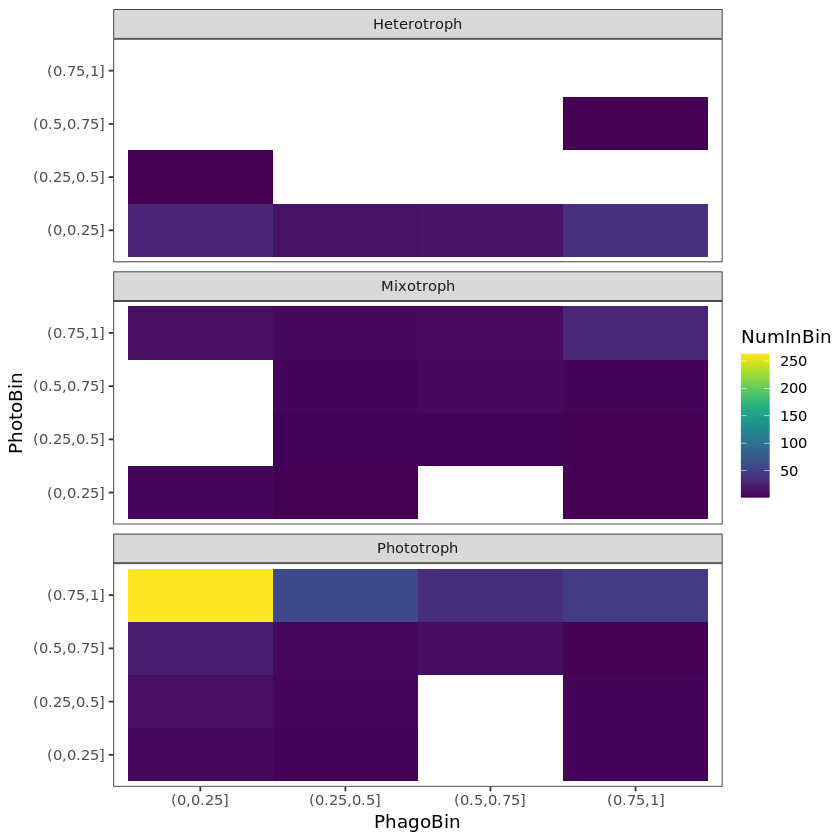

In [51]:
burns_binned = burns_combined %>% dplyr::group_by(Trophic.mode,PhagoBin,PhotoBin) %>% 
    dplyr::summarize(MeanHeterotrophy = mean(HeterotrophyScore), NumInBin = n())
ggplot(burns_binned) + geom_tile(aes(x = PhagoBin,y=PhotoBin, fill = NumInBin)) + 
    facet_wrap(~Trophic.mode,ncol=1) + theme_test() + scale_fill_viridis()

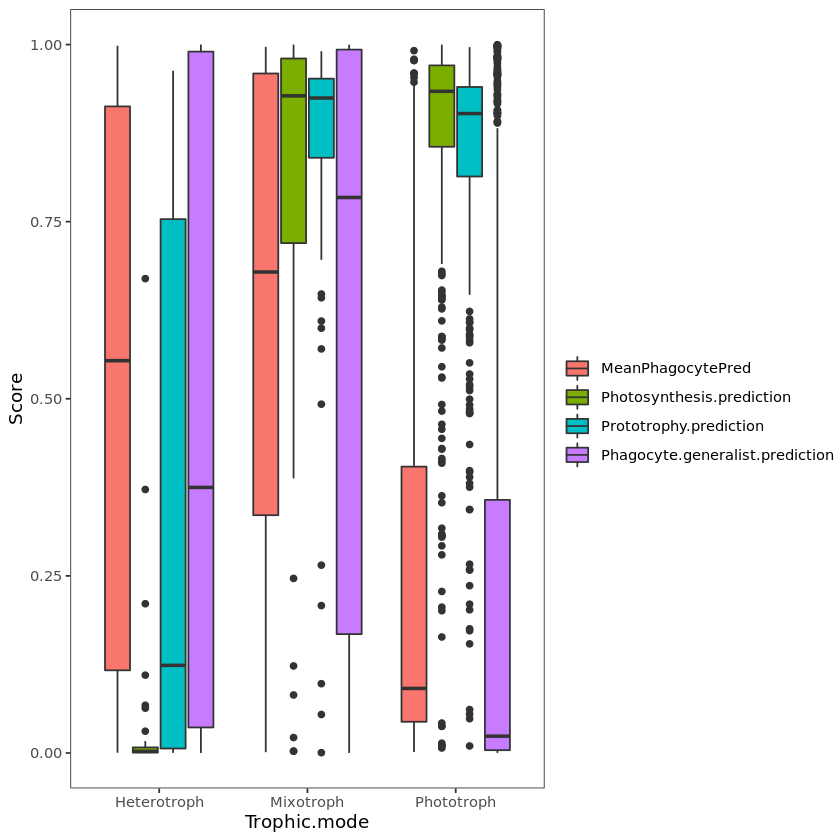

In [112]:
ggplot(combined_metrics,aes(x=Trophic.mode,fill=variable,y=value)) + 
    geom_boxplot() + theme_test() + scale_fill_discrete(name="") + ylab("Score")

In [19]:
all_tax_info = mmetsp_allfeatures %>% dplyr::mutate(Name_to_Use = Source_ID) %>% dplyr::bind_rows(eukprot_withtax)
sagenista_ciliophora = all_tax_info %>% dplyr::filter((Division == "Ciliophora") | (Division == "Sagenista"))

In [20]:
sagenista_ciliophora_vita = (sagenista_ciliophora %>% dplyr::select(starts_with("K") & !starts_with("Ke")))[ , vita$var]
pred_sag <- predict(optimal_rf, sagenista_ciliophora_vita)
table(pred_sag$predictions)


Heterotroph   Mixotroph  Phototroph 
         45           1           0 

In [22]:
sagenista_selected = (sagenista_ciliophora %>% dplyr::select(starts_with(c("K","Name_to_Use"))) %>%
     dplyr::select(!starts_with("Ke")))[ , c(vita$var,"Name_to_Use")]

In [23]:
##### CALCULATE HETEROTROPHY INDEX SCORES #####
listed_outputs = classify_points_binom(sagenista_selected, training_scores, "Name_to_Use")
score_matrix_sag = listed_outputs[[1]]
predicted_by_heterotrophyindex_sag = listed_outputs[[2]]
predicted_by_maxscore_sag = listed_outputs[[3]]

In [26]:
predicted_by_heterotrophyindex_sag$Predicted.trophic.mode.rf = as.character(pred_sag$predictions)
predicted_by_heterotrophyindex_trop = predicted_by_heterotrophyindex_sag %>% 
    dplyr::left_join(all_tax_info,by=c("Source_ID"="Name_to_Use")) %>% 
    dplyr::select(c(colnames(predicted_by_heterotrophyindex_sag),"Division","Trophic.mode"))

In [27]:
predicted_by_heterotrophyindex_trop

Source_ID,HeterotrophyScore,Predicted.trophic.mode,Predicted.trophic.mode.rf,Division,Trophic.mode
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
Ichthyophthirius_multifilii,111,Heterotroph,Heterotroph,Ciliophora,Heterotroph
MMETSP0123,55,Heterotroph,Heterotroph,Ciliophora,Heterotroph
MMETSP0125,60,Heterotroph,Heterotroph,Ciliophora,Heterotroph
MMETSP0126,20,Heterotroph,Heterotroph,Ciliophora,Heterotroph
MMETSP0127,117,Heterotroph,Heterotroph,Ciliophora,Heterotroph
MMETSP0198,7,Heterotroph,Heterotroph,Sagenista,Heterotroph
MMETSP0199,2,Mixotroph,Heterotroph,Sagenista,Heterotroph
MMETSP0205,28,Heterotroph,Heterotroph,Ciliophora,Heterotroph
MMETSP0206,45,Heterotroph,Heterotroph,Ciliophora,Heterotroph


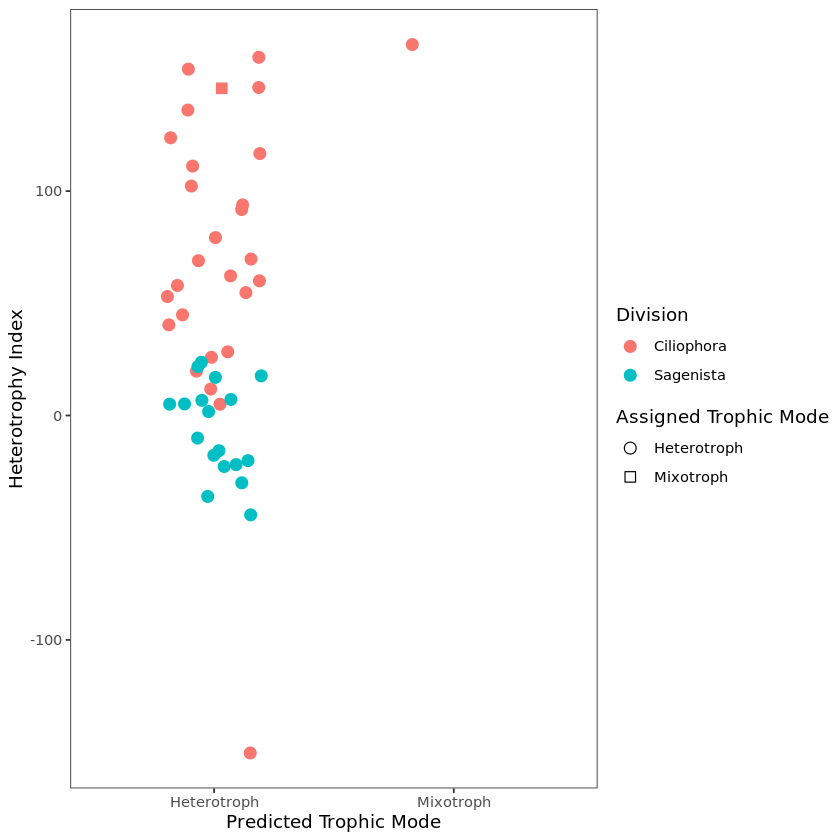

In [30]:
ggplot(predicted_by_heterotrophyindex_trop) + 
    geom_jitter(aes(x = Predicted.trophic.mode.rf, y = HeterotrophyScore, fill = Division,
                    shape = Trophic.mode, col = Division),
                size=3,width=0.2) + 
    scale_shape_manual(values=c(21,22), name = "Assigned Trophic Mode") + 
    theme_test() + xlab("Predicted Trophic Mode") + ylab("Heterotrophy Index")
ggsave("ciliophora_sagenista.png",width=5,height=5,units="in")

In [16]:
##### FILTER MAGS BY BUSCO COMPLETENESS #####
busco_completeness = read.csv(file.path("..","data","EUK_BUSCO_CC.csv"))
colnames(busco_completeness) = c("MAGs","Completeness","Contamination")
complete_MAGs <- busco_completeness$MAGs[busco_completeness$Completeness > 30]

listed_outputs_mags = classify_points_binom(mags_unknown%>%dplyr::mutate(MAGs=rownames(.)), 
                                            training_scores, "MAGs")
score_matrix = listed_outputs_mags[[1]]
predicted_by_heterotrophyindex = listed_outputs_mags[[2]]
predicted_by_maxscore = listed_outputs_mags[[3]]

combo_for_plot = mags_unknown %>% 
                dplyr::mutate(MAGs=rownames(.)) %>% 
                dplyr::inner_join(predicted_by_heterotrophyindex,by=c("MAGs"="Source_ID"))

busco_compare = combo_for_plot %>% dplyr::left_join(busco_completeness, by = "MAGs")
mag_info = data.frame("MAGs" = combo_for_plot$MAGs, "PredictedTrophicMode" = pred$predictions,
                      "HeterotrophyScore" = combo_for_plot$HeterotrophyScore, 
                      "Completeness" = busco_compare$Completeness) %>%
    dplyr::filter(MAGs %in% complete_MAGs) 

In [17]:
head(mag_info)

,MAGs,PredictedTrophicMode,HeterotrophyScore,Completeness
,<fct>,<fct>,<dbl>,<dbl>
1,MS-all-SRF-0-8-5-00_bin-584,Phototroph,-234,60.00000
2,MS-all-SRF-20-180-00_bin-27,Heterotroph,174,67.84314
3,SAO-all-DCM-180-2000-00_bin-12,Heterotroph,65,34.50980
4,SPO-all-SRF-5-20-00_bin-13,Phototroph,-239,81.17647
5,NPO-all-SRF-20-180-00_bin-76,Phototroph,-212,68.23529
6,MS-all-DCM-0-8-5-00_bin-94,Heterotroph,29,45.49020


In [18]:
write.csv(mag_info,"/vortexfs1/omics/alexander/share/mag_heterotrophy_rf_13May2021.csv")

In [21]:
busco_compare = combo_for_plot %>% dplyr::left_join(busco_completeness, by = "MAGs")

In [35]:
head(mag_info_class)

,MAGs,PredictedTrophicMode,HeterotrophyScore,Completeness,Domain,Supergroup,Phylum,Class,Order,Family,Genus,Species
,<fct>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,MS-all-SRF-0-8-5-00_bin-584,Phototroph,-234,60.00000,Eukaryota,Archaeplastida,Chlorophyta,Mamiellophyceae,Mamiellales,Micromonas,-,-
2,MS-all-SRF-20-180-00_bin-27,Heterotroph,174,67.84314,Eukaryota,Metazoa,Arthropoda,-,-,-,-,-
3,SAO-all-DCM-180-2000-00_bin-12,Heterotroph,65,34.50980,Eukaryota,Metazoa,Arthropoda,-,-,-,-,-
4,SPO-all-SRF-5-20-00_bin-13,Phototroph,-239,81.17647,Eukaryota,Archaeplastida,Chlorophyta,-,-,-,-,-
5,NPO-all-SRF-20-180-00_bin-76,Phototroph,-212,68.23529,Eukaryota,Archaeplastida,Chlorophyta,-,-,-,-,-
6,MS-all-DCM-0-8-5-00_bin-94,Heterotroph,29,45.49020,Eukaryota,-,-,-,-,-,-,-


Warning message:
“Computation failed in `stat_smooth()`:
number of iterations exceeded maximum of 20000”
Saving 6.67 x 6.67 in image

Warning message:
“Computation failed in `stat_smooth()`:
number of iterations exceeded maximum of 20000”


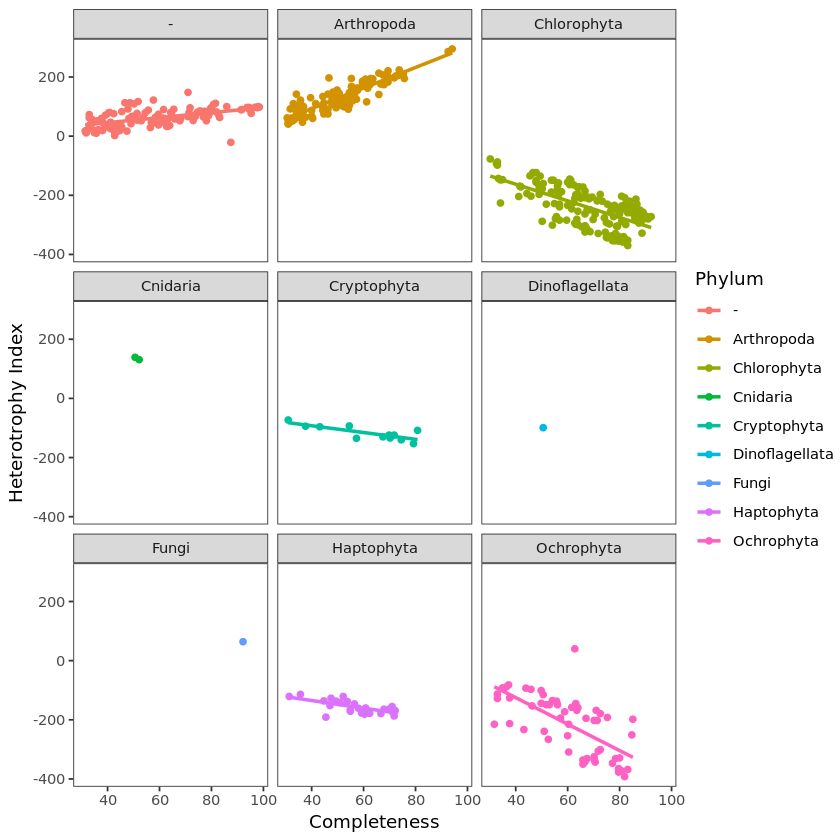

In [57]:
ggplot(mag_info_class) + geom_point(aes(x = Completeness, y = HeterotrophyScore, 
                                        col = Phylum)) + 
    facet_wrap(~Phylum) + 
    geom_smooth(aes(group=Phylum, x = Completeness, y= HeterotrophyScore, col = Phylum),
              method = "nls", formula = y ~ a * x + b, se = FALSE,
              method.args = list(start=c(a=20, b=0), 
                                 control=nls.control(maxiter=20000))) + theme_test() + 
    ylab("Heterotrophy Index")
ggsave(file.path("..","si-figures","heterotrophyindex_group.png"))

In [61]:
vita_vars

[1] K00003 K00010 K00018 K00019 K00023 K00033 K00034 K00036 K00053 K00055
  [11] K00060 K00067 K00069 K00083 K00099 K00101 K00103 K00116 K00128 K00134
  [21] K00138 K00143 K00145 K00161 K00162 K00163 K00208 K00209 K00218 K00228
  [31] K00231 K00232 K00239 K00255 K00274 K00284 K00288 K00290 K00314 K00315
  [41] K00325 K00326 K00330 K00333 K00338 K00339 K00350 K00351 K00354 K00364
  [51] K00366 K00381 K00382 K00392 K00411 K00415 K00418 K00423 K00432 K00452
  [61] K00461 K00463 K00471 K00474 K00479 K00480 K00514 K00520 K00525 K00529
  [71] K00537 K00542 K00544 K00555 K00559 K00564 K00565 K00592 K00598 K00613
  [81] K00614 K00616 K00620 K00630 K00632 K00637 K00639 K00640 K00643 K00648
  [91] K00649 K00651 K00654 K00655 K00665 K00666 K00667 K00668 K00674 K00683
 [101] K00693 K00694 K00695 K00699 K00718 K00734 K00748 K00749 K00772 K00794
 [111] K00795 K00804 K00809 K00810 K00813 K00822 K00825 K00826 K00845 K00846
 [121] K00851 K00853 K00855 K00861 K00865 K00873 K00874 K00878 K00891 K00894
 [131] K00901 K00905 K00911 K00919 K00920 K00922 K00926 K00930 K00933 K00934
 [141] K00945 K00948 K00966 K00972 K00975 K00987 K00991 K00995 K00997 K01006
 [151] K01007 K01012 K01021 K01027 K01053 K01054 K01057 K01065 K01067 K01080
 [161] K01090 K01092 K01095 K01100 K01102 K01106 K01114 K01118 K01120 K01124
 [171] K01125 K01127 K01129 K01134 K01136 K01151 K01158 K01159 K01178 K01182
 [181] K01185 K01186 K01195 K01196 K01198 K01200 K01202 K01205 K01209 K01217
 [191] K01218 K01225 K01228 K01235 K01241 K01244 K01245 K01251 K01255 K01262
 [201] K01266 K01270 K01275 K01277 K01279 K01283 K01286 K01288 K01297 K01299
 [211] K01336 K01358 K01363 K01379 K01409 K01414 K01431 K01432 K01448 K01477
 [221] K01485 K01494 K01505 K01507 K01511 K01518 K01527 K01530 K01531 K01551
 [231] K01556 K01560 K01568 K01569 K01593 K01599 K01601 K01602 K01619 K01624
 [241] K01625 K01626 K01639 K01649 K01655 K01659 K01661 K01662 K01674 K01676
 [251] K01679 K01684 K01691 K01693 K01696 K01703 K01704 K01705 K01719 K01720
 [261] K01721 K01725 K01738 K01745 K01751 K01754 K01758 K01770 K01772 K01777
 [271] K01778 K01779 K01783 K01787 K01792 K01796 K01799 K01805 K01808 K01811
 [281] K01829 K01840 K01841 K01845 K01854 K01866 K01867 K01868 K01870 K01872
 [291] K01873 K01878 K01881 K01886 K01892 K01893 K01895 K01914 K01919 K01939
 [301] K01954 K01961 K01963 K01974 K02003 K02014 K02015 K02016 K02030 K02045
 [311] K02046 K02047 K02087 K02088 K02090 K02094 K02110 K02114 K02115 K02116
 [321] K02127 K02128 K02137 K02138 K02145 K02146 K02149 K02150 K02155 K02156
 [331] K02207 K02211 K02217 K02221 K02264 K02266 K02284 K02291 K02293 K02300
 [341] K02302 K02303 K02304 K02309 K02316 K02318 K02338 K02346 K02348 K02356
 [351] K02357 K02358 K02359 K02371 K02372 K02390 K02395 K02407 K02410 K02413
 [361] K02414 K02415 K02416 K02422 K02426 K02427 K02429 K02431 K02440 K02446
 [371] K02449 K02469 K02470 K02471 K02492 K02496 K02500 K02515 K02518 K02520
 [381] K02533 K02552 K02564 K02575 K02614 K02617 K02634 K02636 K02638 K02640
 [391] K02641 K02689 K02692 K02693 K02694 K02696 K02698 K02699 K02700 K02701
 [401] K02703 K02704 K02705 K02706 K02708 K02712 K02714 K02716 K02717 K02719
 [411] K02720 K02723 K02725 K02726 K02732 K02734 K02736 K02805 K02836 K02837
 [421] K02838 K02857 K02864 K02866 K02867 K02873 K02876 K02877 K02879 K02882
 [431] K02883 K02885 K02889 K02898 K02901 K02902 K02903 K02904 K02906 K02909
 [441] K02910 K02912 K02917 K02929 K02930 K02936 K02938 K02942 K02945 K02947
 [451] K02950 K02951 K02955 K02958 K02962 K02964 K02965 K02968 K02974 K02976
 [461] K02985 K02987 K02996 K02998 K03018 K03027 K03028 K03029 K03030 K03032
 [471] K03035 K03037 K03039 K03046 K03060 K03063 K03065 K03070 K03079 K03092
 [481] K03094 K03099 K03100 K03101 K03106 K03110 K03116 K03119 K03120 K03131
 [491] K03142 K03146 K03147 K03150 K03151 K03153 K03163 K03164 K03168 K03217
 [501] K03234 K03235 K03243 K03245 K03248 K03253 K03259 K03260 K03262 K03265
 [511] K03283 K03286 K03292 K03301 K03317 K03319 K03320 K03324 K03331 K03332

In [68]:
##### FILTER MAGS BY BUSCO COMPLETENESS #####
busco_completeness = read.csv(file.path("..","data","EUK_BUSCO_CC.csv"))
colnames(busco_completeness) = c("MAGs","Completeness","Contamination")
complete_MAGs <- busco_completeness$MAGs[busco_completeness$Completeness > 30]

listed_outputs_mags = classify_points_binom(mags_unknown%>%dplyr::mutate(MAGs=rownames(.)), 
                                            training_scores, "MAGs")
score_matrix = listed_outputs_mags[[1]]
predicted_by_heterotrophyindex = listed_outputs_mags[[2]]
predicted_by_maxscore = listed_outputs_mags[[3]]

combo_for_plot = mags_unknown %>% 
                dplyr::mutate(MAGs=rownames(.)) %>% 
                dplyr::inner_join(predicted_by_heterotrophyindex,by=c("MAGs"="Source_ID"))

mag_info = data.frame("MAGs" = combo_for_plot$MAGs, "PredictedTrophicMode" = pred$predictions,
                      "HeterotrophyScore" = combo_for_plot$HeterotrophyScore) %>%
    dplyr::filter(MAGs %in% complete_MAGs) 

In [21]:
##### READ IN METADATA AND TPM MATRIX #####
datamatrix = read.csv(file.path("/vortexfs1","omics","alexander","halexander","2020-tara-mag-abund",
                                      "MAG_tpm.csv"))
environmental_metadata = read.csv(file.path("..","data","PRJEB4352_metaG_wenv_PE.txt"),sep="\t")
data_mat_trans = data.frame(t(datamatrix)) %>% rownames_to_column("run_accession")
colnames(data_mat_trans)[2:ncol(data_mat_trans)] = as.character(datamatrix$Genome)
metadata_merged = environmental_metadata %>% dplyr::inner_join(data_mat_trans, by = c("run_accession"))
enviro_long = metadata_merged %>% pivot_longer(cols = as.character(datamatrix$Genome), 
                                 names_to="Genome", values_to="Abundance")

In [25]:
head(metadata_merged)

,X,study_accession,sample_accession,secondary_sample_accession,experiment_accession,run_accession,tax_id,scientific_name,instrument_model,library_layout,⋯,NAO-all-MIX-0-8-5-00_bin-163,SO-all-SRF-5-20-00_bin-18,SPO-all-SRF-0-8-5-00_bin-102,NAO-all-MES-0-8-5-00_bin-44,MS-all-SRF-0-8-5-00_bin-342,SPO-all-SRF-5-20-00_bin-118,SPO-all-DCM-0-8-5-00_bin-332,SAO-all-DCM-0-8-5-00_bin-548,SPO-CHIL-SRF-180-2000-00_bin-58,SPO-all-SRF-5-20-00_bin-92
,<int>,<fct>,<fct>,<fct>,<fct>,<chr>,<int>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,0,PRJEB4352,SAMEA2656965,ERS488900,ERX1771177,ERR1700889,408172,marine metagenome,Illumina HiSeq 2000,PAIRED,⋯,0.000000e+00,5.306862e-01,2.267936e-01,0.000000e+00,7.159056e+03,8.190798e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,1,PRJEB4352,SAMEA2620205,ERS489054,ERX1771189,ERR1700890,408172,marine metagenome,Illumina HiSeq 2000,PAIRED,⋯,0.000000e+00,4.236614e-02,4.224630e-01,0.000000e+00,8.242352e+01,1.818410e+03,3.103495e-01,0.000000e+00,1.427291e-01,0.000000e+00
3,2,PRJEB4352,SAMEA2623506,ERS493999,ERX1771187,ERR1700891,408172,marine metagenome,Illumina HiSeq 2000,PAIRED,⋯,3.465425e+00,0.000000e+00,4.277371e+02,6.183238e+00,1.557246e+02,5.046065e+02,1.384246e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,3,PRJEB4352,SAMEA2620172,ERS489013,ERX1771191,ERR1700892,408172,marine metagenome,Illumina HiSeq 2000,PAIRED,⋯,3.254663e-01,0.000000e+00,2.123645e+01,2.622988e+04,1.927107e+02,4.366101e+02,0.000000e+00,2.510827e+01,0.000000e+00,0.000000e+00
5,4,PRJEB4352,SAMEA2730950,ERS494049,ERX1771202,ERR1700893,408172,marine metagenome,Illumina HiSeq 2000,PAIRED,⋯,1.281224e+01,8.383611e+00,6.383922e+01,7.980373e+00,6.724142e+02,6.708563e+02,6.699645e+00,1.797104e+01,2.567629e+00,0.000000e+00
6,5,PRJEB4352,SAMEA2619554,ERS488153,ERX1771192,ERR1700894,408172,marine metagenome,Illumina HiSeq 2000,PAIRED,⋯,1.184838e+02,2.335215e+00,3.027192e+01,6.112960e+00,1.318803e+03,2.124886e+02,1.069151e+01,1.887882e+02,0.000000e+00,3.568106e+00


In [24]:
enviro_long = metadata_merged %>% pivot_longer(cols = as.character(datamatrix$Genome), 
                                 names_to="Genome", values_to="Abundance")

In [25]:
##### CALCULATE PCA ON MAG DATA #####
dist <- vegdist(mags_unknown %>% 
                dplyr::filter(rownames(.) %in% complete_MAGs) %>% 
                mutate_all(as.numeric),  method = "jaccard")
res.pca <- prcomp(dist, scale = TRUE)
PCinfo = data.frame(res.pca$x)


In [33]:
##### COMBINE ALL MAG INFORMATION #####

mag_info_class =  mag_info %>% 
    dplyr::mutate(Classifications = get_euk_prok(mag_info$MAGs)$classification) %>%
    separate(Classifications, sep = ";", fill = "left",
                    c("Domain","Supergroup","Phylum","Class",
                             "Order","Family","Genus","Species")) 

results_PCA = data.frame("MAGs" = mag_info$MAGs) %>% 
    dplyr::mutate(PC1 = PCinfo$PC1,PC2 = PCinfo$PC2) %>%
    dplyr::inner_join(mag_info,by="MAGs")

In [ ]:
##### VISUALIZATIONS #####

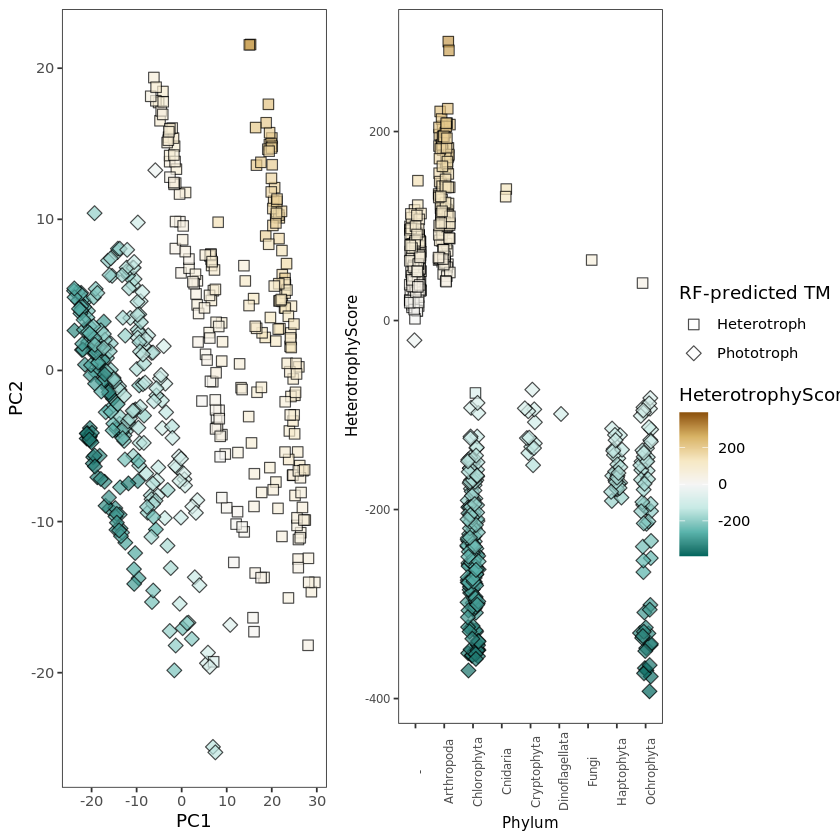

In [21]:
pacman::p_load(cowplot)
limit <- max(abs(results_PCA$HeterotrophyScore)) * c(-1, 1)
pca_plot = ggplot(results_PCA) + geom_point(aes(x=PC1,y=PC2,
                                     shape=PredictedTrophicMode,
                                     fill=HeterotrophyScore),color="black",size=3,alpha=0.7) + 
    scale_shape_manual(name="RF-predicted TM", values = c(22,23,24)) + 
  scale_fill_distiller(type = "div", limit = limit) + 
    theme_test()
legend_all = get_legend(pca_plot)
classification_plot = ggplot(mag_info_class) + 
    geom_jitter(aes(x=Phylum,shape=PredictedTrophicMode,
                    y=HeterotrophyScore, fill = HeterotrophyScore),
                color="black",size=3,alpha=0.7,width=0.2) + 
    scale_shape_manual(name="RF-predicted TM", values = c(22,23,24)) +  
    theme_test() + 
    scale_fill_distiller(type = "div", limit = limit) + 
    theme(legend.position = "none", 
          text = element_text(size = 9),
          axis.text.x = element_text(angle = 90, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5))
cowplot::plot_grid(pca_plot+theme(legend.position="none"),
                   classification_plot+theme(legend.position="none"),
                  legend_all,rel_widths=c(1,1,0.5),ncol=3)
ggsave("pca_plusheterotrophy.png",width=10,height=6,units="in",dpi=400)

In [ ]:
##### PROCESSING ENVIRONMENTAL METADATA (LAT/LON) #####
pacman::p_load("cowplot", "googleway", "ggplot2", "ggrepel", 
               "ggspatial", "libwgeom", "sf", "rnaturalearth", "rnaturalearthdata")

enviro_merged = enviro_long %>% dplyr::inner_join(mag_info_class, by = c("Genome"="MAGs"))
depth_compare = enviro_merged %>% 
    dplyr::mutate(TPMWeightedHeterotrophy = as.numeric(as.character(Abundance)) * HeterotrophyScore) %>%
    dplyr::mutate(DepthCat = ntile(Depth..nominal, 6),DepthRange = cut_interval(Depth..nominal, n = 6)) %>% 
    dplyr::select(Depth..nominal,DepthCat,DepthRange,HeterotrophyScore)

summarized_stations = enviro_merged %>% 
    dplyr::mutate(TPMWeightedHeterotrophy = as.numeric(as.character(Abundance)) * HeterotrophyScore) %>%
    dplyr::mutate(DepthRange = cut(Depth..nominal,
        breaks = c(0,as.character(quantile(enviro_merged$Depth..nominal, c(0.5,0.6,0.75,0.9,0.95,1)))))) %>%
    dplyr::group_by(Longitude..of.the.geographic.coordinate.....,Latitude..of.the.geographic.coordinate.....,
                    DepthRange,Depth..nominal) %>% 
    dplyr::summarize(MeanTPMHeterotrophy = mean(TPMWeightedHeterotrophy))

In [ ]:
head(enviro_merged)

In [ ]:
##### VISUALIZE ENVIRONMENTAL METADATA #####
world <- ne_countries(scale = "medium", returnclass = "sf")
heterotrophy_global = ggplot(data = world) + theme_bw() + 
    geom_sf(color = "black", fill = "gray") + 
    geom_jitter(data=summarized_stations, 
               aes(x = Longitude..of.the.geographic.coordinate.....,
                   y = Latitude..of.the.geographic.coordinate.....,
                   fill = MeanTPMHeterotrophy), alpha = 0.3, pch=21, width = 3) + 
    geom_point(data = summarized_stations %>% dplyr::filter(MeanTPMHeterotrophy > 255386.3),
              aes(x = Longitude..of.the.geographic.coordinate.....,
                   y = Latitude..of.the.geographic.coordinate.....,
                   fill = MeanTPMHeterotrophy), shape = "*", size = 4) +
    facet_wrap(~DepthRange) + 
    scale_fill_gradientn(colors = c("blue","yellow","orange","red"), name = "TPM-Weighted H-score") + 
    xlab("") + ylab("")
heterotrophy_global
ggsave("heterotrophy_global.png",width=10,height=6,units="in",dpi=400)

In [89]:
##### READ IN AND PROCESS BURNS MODEL RESULTS #####
burns_output = read.csv(file.path("..","data","ptm_Burns_output.tsv"),sep="\t")
burns_output_named = burns_output %>% tidyr::separate(Genome,into=c("MAGName","HMMinfo"),sep="\\.")
busco_completeness = read.csv(file.path("..","data","EUK_BUSCO_CC.csv"))
colnames(busco_completeness) = c("MAGs","Completeness","Contamination")

complete_MAGs <- busco_completeness$MAGs[busco_completeness$Completeness > 30]
burns_output_named = burns_output_named %>% dplyr::filter(MAGName %in% complete_MAGs) %>%
                        dplyr::mutate(Taxonomy=get_euk_prok(MAGName)$classification) %>%
                        separate(Taxonomy, sep = ";", fill = "left",
                                 c("Domain","Supergroup","Phylum","Class",
                                   "Order","Family","Genus","Species")) 

Warning message:
“Expected 2 pieces. Additional pieces discarded in 995 rows [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, ...].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 3 rows [1, 140, 485].”


In [90]:
head(burns_output_named)

,MAGName,HMMinfo,Phagocyte.generalist.prediction,Phagocyte.entamoebid.prediction,Phagocyte.rozellid.prediction,Prototrophy.prediction,Photosynthesis.prediction,Domain,Supergroup,Phylum,Class,Order,Family,Genus,Species
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,IO-all-DCM-0-8-5-00_bin-104,x,0.93373179,0.495987694,0.7570036,0.6248311,0.535923135,Eukaryota,Hacrobia,Cryptophyta,Cryptophyceae,-,-,-,-
2,IO-all-DCM-0-8-5-00_bin-111,x,0.92894893,0.962047667,0.4779954,0.8015032,0.715404745,Eukaryota,Hacrobia,Haptophyta,Prymnesiophyceae,-,-,-,-
3,IO-all-DCM-0-8-5-00_bin-12,x,0.99470130,0.974080566,0.8969910,0.8620129,0.591672747,Eukaryota,Hacrobia,Haptophyta,Prymnesiophyceae,-,-,-,-
4,IO-all-DCM-0-8-5-00_bin-120,x,0.01517808,0.004762661,0.1311424,0.9185766,0.999249180,Eukaryota,Archaeplastida,Chlorophyta,Mamiellophyceae,Mamiellales,Micromonas,Micromonas sp.,-
5,IO-all-DCM-0-8-5-00_bin-157,x,0.99383302,0.996793283,0.9739918,0.2657302,0.004353995,Eukaryota,-,-,-,-,-,-,-
6,IO-all-DCM-0-8-5-00_bin-17,x,0.02702141,0.120605234,0.2971786,0.8109665,0.951543522,Eukaryota,Archaeplastida,Chlorophyta,-,-,-,-,-


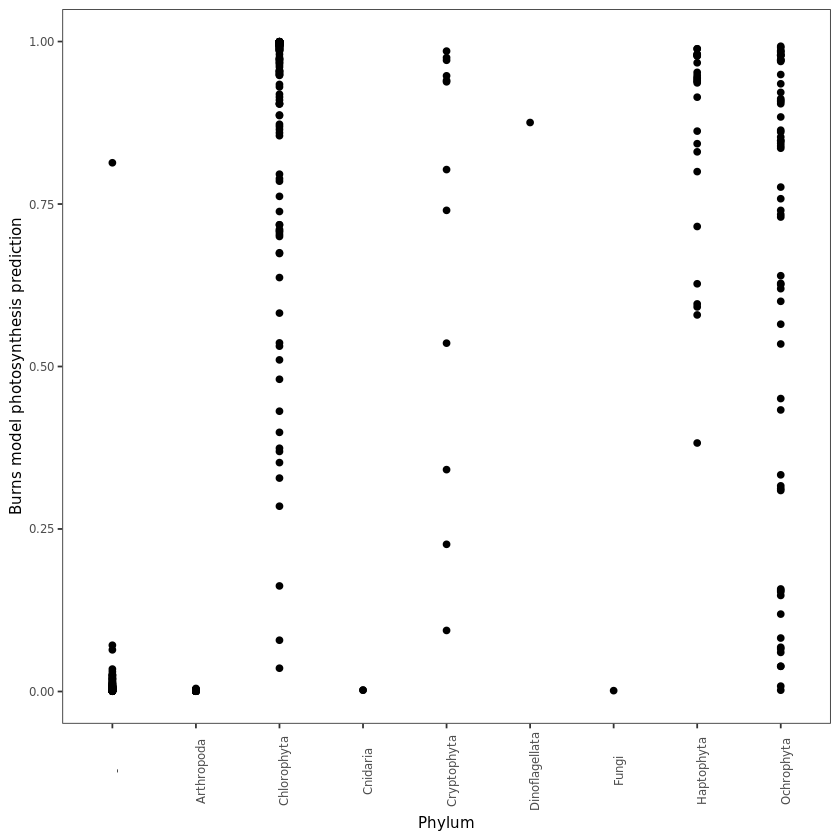

In [91]:
##### VISUALIZE BURNS MODEL OUTPUT WITH TAXONOMY #####
ggplot(burns_output_named) + geom_point(aes(x = Phylum, y = Photosynthesis.prediction)) + theme_test() + 
    theme(legend.position = "none", 
          text = element_text(size = 9),
          axis.text.x = element_text(angle = 90, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5)) + 
    ylab("Burns model photosynthesis prediction")

In [186]:
het_merged_groups

MAGs,PredictedTrophicMode,HeterotrophyScore,Domain,Supergroup,Phylum,Class,Order,Family,Genus,Species,HMMinfo,Phagocyte.generalist.prediction,Phagocyte.entamoebid.prediction,Phagocyte.rozellid.prediction,Prototrophy.prediction,Photosynthesis.prediction,groups,groups_full
<chr>,<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
MS-all-SRF-0-8-5-00_bin-584,Phototroph,-234,Eukaryota,Archaeplastida,Chlorophyta,Mamiellophyceae,Mamiellales,Micromonas,-,-,x,0.001930192,0.004465566,0.01558924,0.8715973132,0.9986586365,Chlorophyta,Archaeplastida;Chlorophyta
MS-all-SRF-20-180-00_bin-27,Heterotroph,174,Eukaryota,Metazoa,Arthropoda,-,-,-,-,-,x,0.579694168,0.780459719,0.51164259,0.0026944711,0.0013343161,Metazoa,Metazoa;Arthropoda
SAO-all-DCM-180-2000-00_bin-12,Heterotroph,65,Eukaryota,Metazoa,Arthropoda,-,-,-,-,-,x,0.002864949,0.072265234,0.10107194,0.0005539486,0.0003371406,Metazoa,Metazoa;Arthropoda
SPO-all-SRF-5-20-00_bin-13,Phototroph,-239,Eukaryota,Archaeplastida,Chlorophyta,-,-,-,-,-,x,0.228463391,0.674007784,0.49716843,0.9586417815,0.9979083194,Chlorophyta,Archaeplastida;Chlorophyta
NPO-all-SRF-20-180-00_bin-76,Phototroph,-212,Eukaryota,Archaeplastida,Chlorophyta,-,-,-,-,-,x,0.129098980,0.629361150,0.53288900,0.9218785701,0.9730283575,Chlorophyta,Archaeplastida;Chlorophyta
MS-all-DCM-0-8-5-00_bin-94,Heterotroph,29,Eukaryota,-,-,-,-,-,-,-,x,0.988114942,0.965053550,0.97561105,0.1404386580,0.0017581603,Eukaryota,-;-
NPO-all-DCM-0-8-5-00_bin-249,Phototroph,-347,Eukaryota,Stramenopiles,Ochrophyta,Bacillariophyta,-,-,-,-,x,0.006696337,0.017490754,0.19302421,0.9233345013,0.9710896006,Ochrophyta,Stramenopiles;Ochrophyta
NPO-all-SRF-0-8-5-00_bin-646,Heterotroph,41,Eukaryota,-,-,-,-,-,-,-,x,0.990565151,0.901798497,0.95734691,0.2265551086,0.0018623025,Eukaryota,-;-
SPO-all-DCM-0-8-5-00_bin-35,Phototroph,-329,Eukaryota,Archaeplastida,Chlorophyta,Mamiellophyceae,Mamiellales,-,-,-,x,0.007766976,0.004902049,0.04082148,0.9662567453,0.9981399402,Chlorophyta,Archaeplastida;Chlorophyta


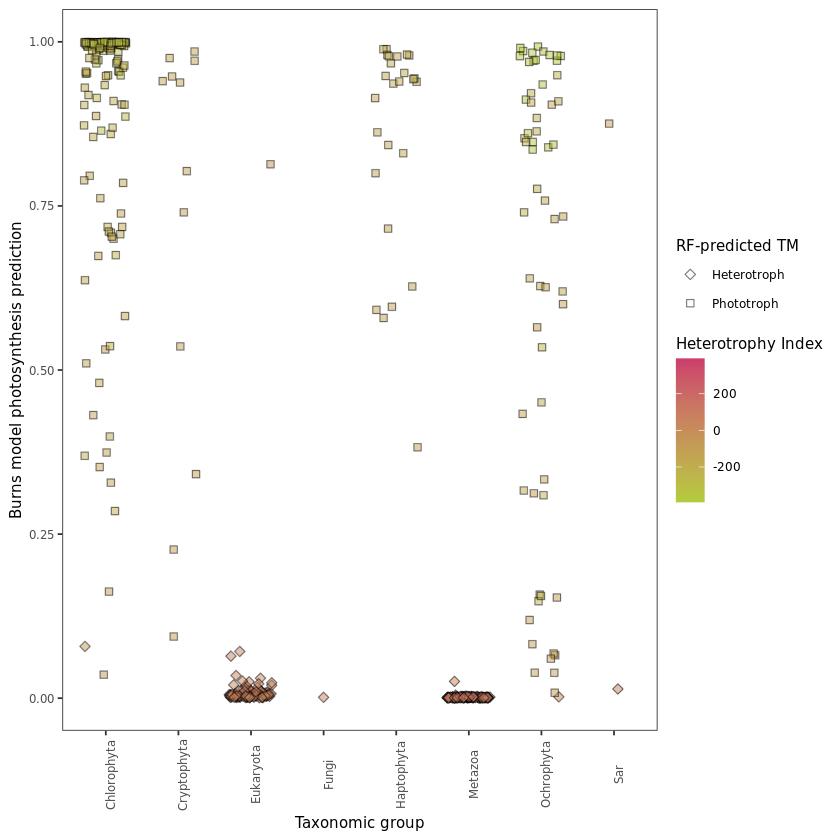

In [239]:
##### VISUALIZE BURNS MODEL OUTPUT WITH HETEROTROPHY SCORE #####
limit <- max(abs(results_PCA$HeterotrophyScore)) * c(-1, 1)

heterotrophy_merged = mag_info_class %>% dplyr::left_join(burns_output_named,
                                                          by=c("MAGs" = "MAGName","Phylum",
                                                               "Class","Order","Family","Genus",
                                                               "Species","Domain","Supergroup"))
het_merged_groups = heterotrophy_merged %>% dplyr::mutate(groups=paste(Supergroup,Phylum,sep=";")) %>%
                        dplyr::mutate(groups_full = as.character(groups)) %>%
                        dplyr::mutate(groups = case_when(grepl("Fungi",groups_full) ~ "Fungi",
                                                         grepl("Metazoa",groups_full) ~ "Metazoa",
                                                         grepl("Chlorophyta",groups_full) ~ "Chlorophyta",
                                                         grepl("Cryptophyta",groups_full) ~ "Cryptophyta",
                                                         grepl("Haptophyta",groups_full) ~ "Haptophyta",
                                                         grepl("Ochrophyta",groups_full) ~ "Ochrophyta",
                                                         grepl("Alveolata",groups_full) ~ "Sar",
                                                         grepl("Stramenopiles",groups_full) ~ "Sar",
                                                         (groups_full == "Alveolata;Ciliophora") ~ "Sar",
                                                         (groups_full == "Alveolata;Dinoflagellata") ~ "Sar",
                                                         (groups_full == "Stramenopiles;-") ~ "Sar",
                                                         (groups_full == "Stramenopiles;") ~ "Sar",
                                                          grepl("Amoebozoa",groups_full)  ~ "Amoebozoa",
                                                         (groups_full == "-;") ~ "Eukaryota",
                                                         (groups_full == "-;-") ~ "Eukaryota",
                                                         (groups_full == ";-") ~ "Eukaryota"))
photsyn_heterotrophy_phylum = ggplot(het_merged_groups) + 
    geom_jitter(aes(x = groups, y = Photosynthesis.prediction,
                                            fill = HeterotrophyScore,
                                            shape = PredictedTrophicMode),
                                          width=0.3, size=2, alpha=0.5) + theme_test() + 
    scale_shape_manual(name="RF-predicted TM", values = c(23,22),breaks=c("Heterotroph","Phototroph")) +  
    #scale_fill_distiller(type = "div", limit = limit, low="#B4CC3D", high="#CC3D6D") + 
    scale_fill_gradient(limits=limit, low="#B4CC3D", high="#CC3D6D", name="Heterotrophy Index") + 
    theme(text = element_text(size = 9),
          axis.text.x = element_text(angle = 90, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5)) + xlab("Taxonomic group") + 
    ylab("Burns model photosynthesis prediction")
photsyn_heterotrophy_phylum

In [26]:
write.csv(heterotrophy_merged %>% dplyr::select(MAGs, PredictedTrophicMode, HeterotrophyScore,
                                      Prototrophy.prediction,Photosynthesis.prediction,
                                      Phagocyte.rozellid.prediction,Phagocyte.generalist.prediction),
          file.path("..","..","output","fortree_10Mar2021.csv"), row.names=FALSE)

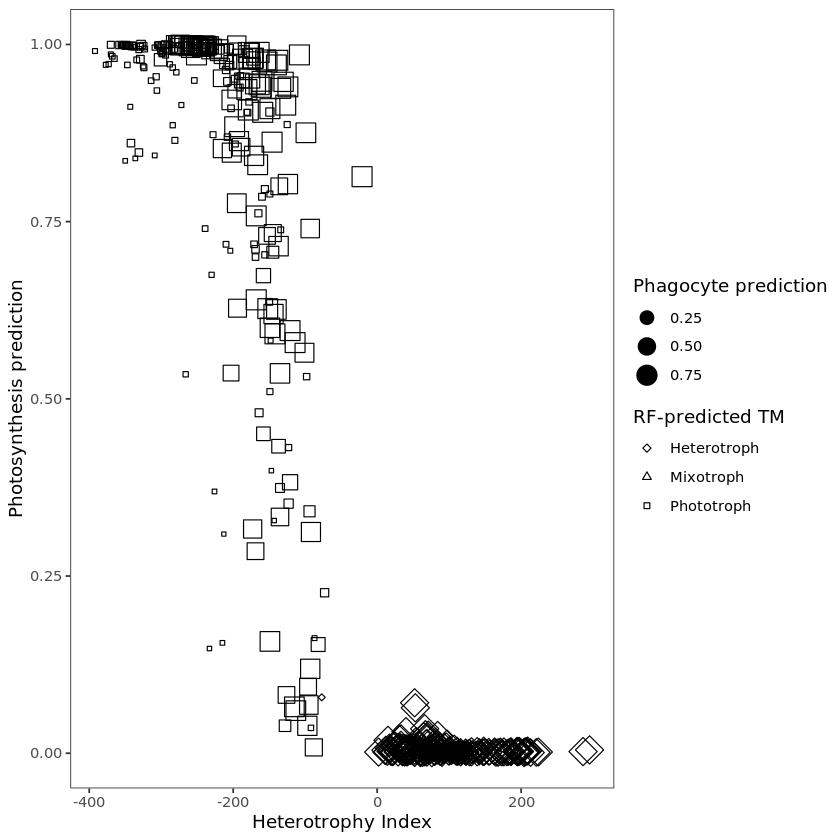

In [237]:
plot_burns_mag = ggplot(het_merged_groups) + geom_point(aes(y=Photosynthesis.prediction,
                                        x=HeterotrophyScore,
                                        shape=PredictedTrophicMode,size=Phagocyte.generalist.prediction)) +
    #scale_shape_manual(values=c(1,2,3),"ML trophic mode") + 
    scale_shape_manual(name="RF-predicted TM", values = c(23,24,22),
                       breaks=c("Heterotroph","Mixotroph","Phototroph"),drop=FALSE) +  
    scale_size(name="Phagocyte prediction") + xlab("Heterotrophy Index") + 
    ylab("Photosynthesis prediction") + 
    scale_color_manual(values=c("#CC3D6D","black","#B4CC3D"),
                       breaks=c("Heterotroph","Mixotroph","Phototroph"),
                       name = "Trophic mode") + 
    theme_test()
plot_burns_mag

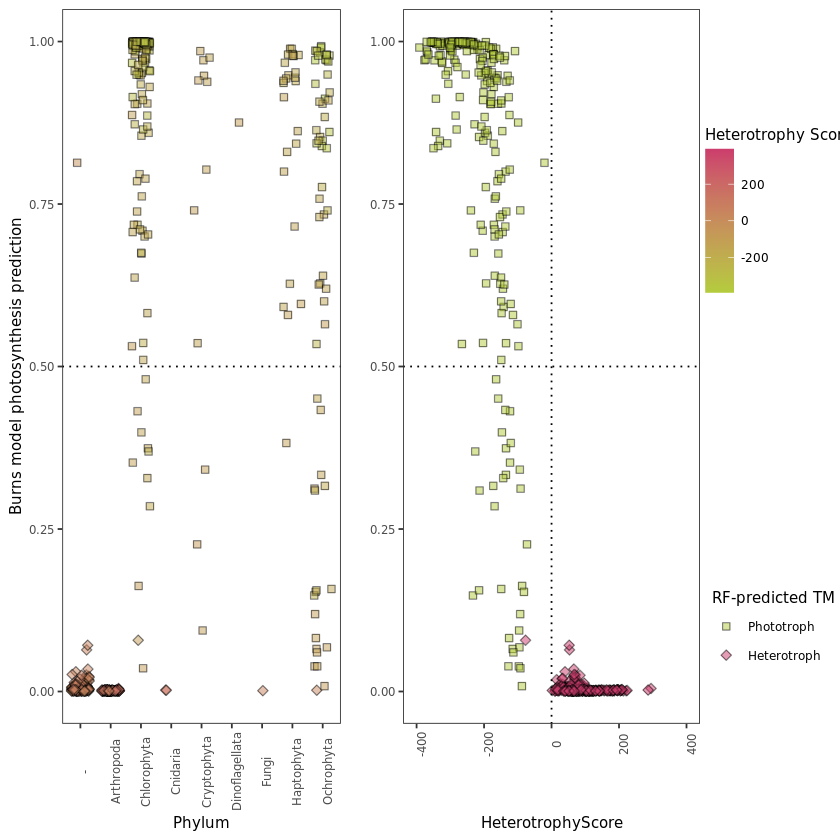

In [175]:
photosyn_prediction <- ggplot(heterotrophy_merged) + geom_jitter(aes(y = Photosynthesis.prediction,
                                              fill = PredictedTrophicMode,
                                              x = HeterotrophyScore,
                                              shape = PredictedTrophicMode),
                                          width=0.3, size=2, alpha=0.5) + theme_test() + 
    scale_shape_manual(name="RF-predicted TM", values = c(22,23),breaks=c("Phototroph","Heterotroph")) +  
    #scale_fill_discrete(name="RF-predicted TM") + 
    scale_fill_manual(name="RF-predicted TM", 
                        values=c("#B4CC3D","#CC3D6D"), breaks=c("Phototroph","Heterotroph")) +
    #guides(fill=guide_legend(override.aes=list(shape=21))) + 
    theme(text = element_text(size = 9),
          axis.text.x = element_text(angle = 90, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5)) + 
    xlim(-400,400) + 
    geom_vline(aes(xintercept=0),linetype="dotted") + 
    geom_hline(aes(yintercept=0.5),linetype="dotted") + 
    ylab("Burns model photosynthesis prediction")
burnsplot_3 = cowplot::plot_grid(photsyn_heterotrophy_phylum + 
    geom_hline(aes(yintercept=0.5),linetype="dotted")+guides(shape=FALSE)+
               theme(legend.position="none"),
                                 photosyn_prediction + theme(legend.position="none",
                                                            plot.margin=grid::unit(c(0,0,0,0), "mm"))+
                                 labs(y = ""),align="h")
burnsplot_3 = cowplot::plot_grid(burnsplot_3,
                                 cowplot::plot_grid(get_legend(photsyn_heterotrophy_phylum+
                                                               guides(shape=FALSE)+
                                                    theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))),
                                                    get_legend(photosyn_prediction+
                                                    theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))),ncol=1),
                                rel_widths=c(1,0.2),ncol=2)
burnsplot_3
#ggsave("burns_model.png",width=12,height=6,units="in",dpi=400)

In [231]:
het_merged_groups = heterotrophy_merged %>% dplyr::mutate(groups=paste(Supergroup,Phylum,sep=";")) %>%
                        dplyr::mutate(groups_full = as.character(groups)) %>%
                        dplyr::mutate(groups = case_when(grepl("Fungi",groups_full) ~ "Fungi",
                                                         grepl("Metazoa",groups_full) ~ "Metazoa",
                                                         grepl("Chlorophyta",groups_full) ~ "Chlorophyta",
                                                         grepl("Cryptophyta",groups_full) ~ "Cryptophyta",
                                                         grepl("Haptophyta",groups_full) ~ "Haptophyta",
                                                         grepl("Ochrophyta",groups_full) ~ "Ochrophyta",
                                                         grepl("Alveolata",groups_full) ~ "Sar",
                                                         grepl("Stramenopiles",groups_full) ~ "Sar",
                                                         (groups_full == "Alveolata;Ciliophora") ~ "Sar",
                                                         (groups_full == "Alveolata;Dinoflagellata") ~ "Sar",
                                                         (groups_full == "Stramenopiles;-") ~ "Sar",
                                                         (groups_full == "Stramenopiles;") ~ "Sar",
                                                          grepl("Amoebozoa",groups_full)  ~ "Amoebozoa",
                                                         (groups_full == "-;") ~ "Eukaryota",
                                                         (groups_full == "-;-") ~ "Eukaryota",
                                                         (groups_full == ";-") ~ "Eukaryota"))

Saving 6.67 x 6.67 in image



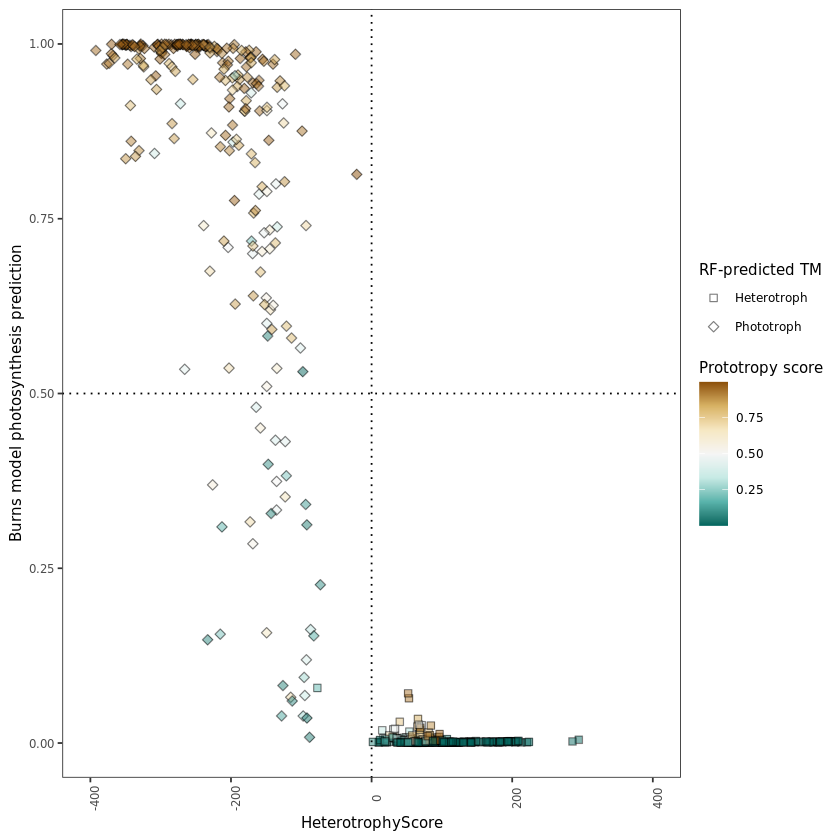

In [105]:
ggplot(heterotrophy_merged) + geom_jitter(aes(y = Photosynthesis.prediction,
                                              fill = Prototrophy.prediction,
                                              x = HeterotrophyScore,
                                              shape = PredictedTrophicMode),
                                          width=0.3, size=2, alpha=0.5) + theme_test() + 
    scale_shape_manual(name="RF-predicted TM", values = c(22,23,24)) +  
    scale_fill_distiller(type = "div", name = "Prototropy score") +
    theme(text = element_text(size = 9),
          axis.text.x = element_text(angle = 90, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5)) + 
    xlim(-400,400) + 
    geom_vline(aes(xintercept=0),linetype="dotted") + 
    geom_hline(aes(yintercept=0.5),linetype="dotted") + 
    ylab("Burns model photosynthesis prediction")
ggsave("burns_model_prototrophy.png",dpi=400)

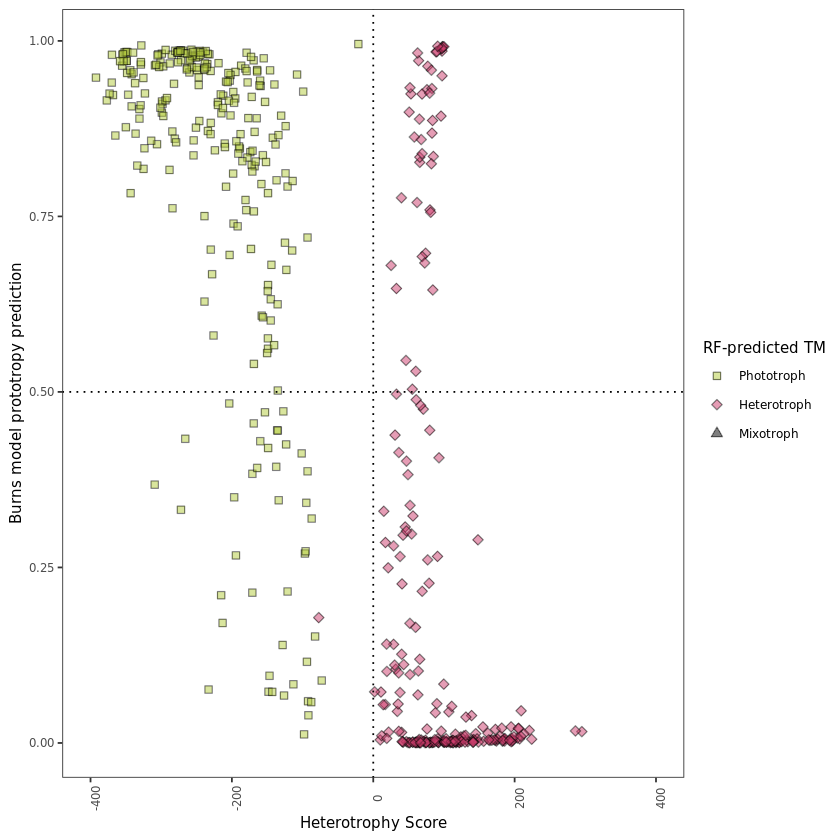

In [151]:
burnsplot_4 = ggplot(heterotrophy_merged) + geom_jitter(aes(y = Prototrophy.prediction,
                                              fill = PredictedTrophicMode,
                                              x = HeterotrophyScore,
                                              shape = PredictedTrophicMode),
                                          width=0.3, size=2, alpha=0.5) + theme_test() + 
    scale_shape_manual(name="RF-predicted TM", values = c(22,23,24),
                       breaks=c("Phototroph","Heterotroph","Mixotroph"),
                      labels = c("Phototroph","Heterotroph","Mixotroph"),drop=FALSE) +  
    scale_fill_manual(name="RF-predicted TM",
                      values=c("#B4CC3D","#CC3D6D","black"),
                      breaks=c("Phototroph","Heterotroph","Mixotroph"),drop=FALSE) +
    theme(text = element_text(size = 9),
          axis.text.x = element_text(angle = 90, vjust = 1),
          axis.text = element_text(size = 7),
          plot.title = element_text(hjust = 0.5)) + 
    xlim(-400,400) + xlab("Heterotrophy Score") + 
    geom_vline(aes(xintercept=0),linetype="dotted") + 
    geom_hline(aes(yintercept=0.5),linetype="dotted") + 
    ylab("Burns model prototropy prediction")
burnsplot_4

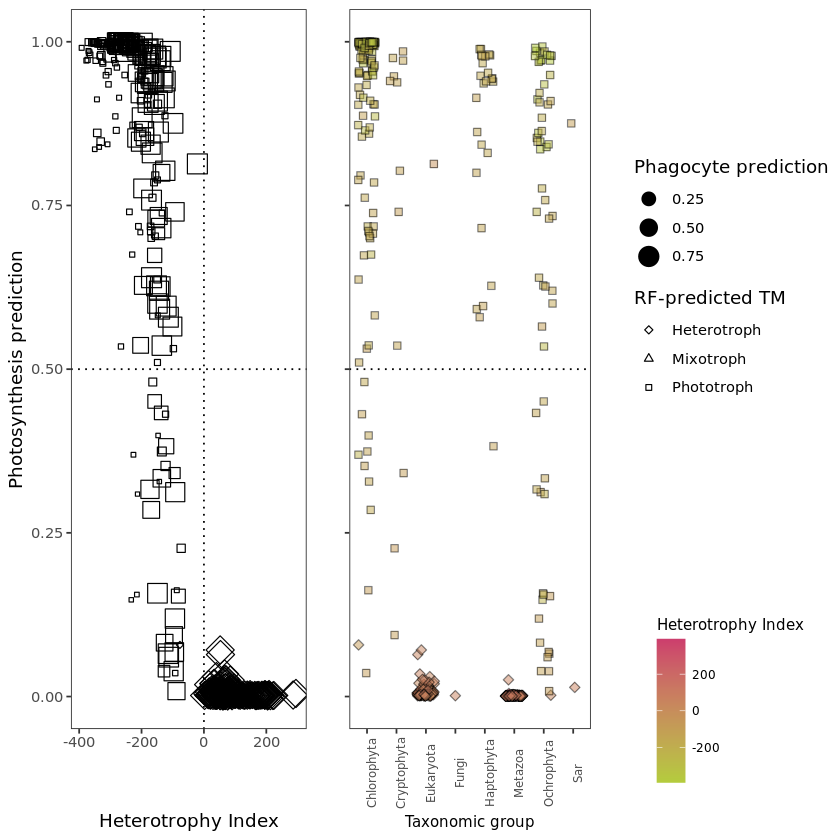

In [247]:
cowplot::plot_grid(cowplot::plot_grid(plot_burns_mag + theme(legend.position="none") + 
    geom_vline(aes(xintercept=0),linetype="dotted") + 
    geom_hline(aes(yintercept=0.5),linetype="dotted"),
                   photsyn_heterotrophy_phylum + labs(y = "") + theme(axis.text.y=element_blank(),
                                                     legend.position="none")+ 
    geom_hline(aes(yintercept=0.5),linetype="dotted"),
                                      align="h",rel_widths=c(1,0.9)),
                   cowplot::plot_grid(get_legend(plot_burns_mag),
                                      get_legend(photsyn_heterotrophy_phylum + guides(shape=FALSE)),
                                      ncol=1,rel_heights=c(1,0.5)),rel_widths=c(1,0.4))
ggsave(file.path("..","si-figures","mag_burns.png"),width=10,height=6,units="in",dpi=350)

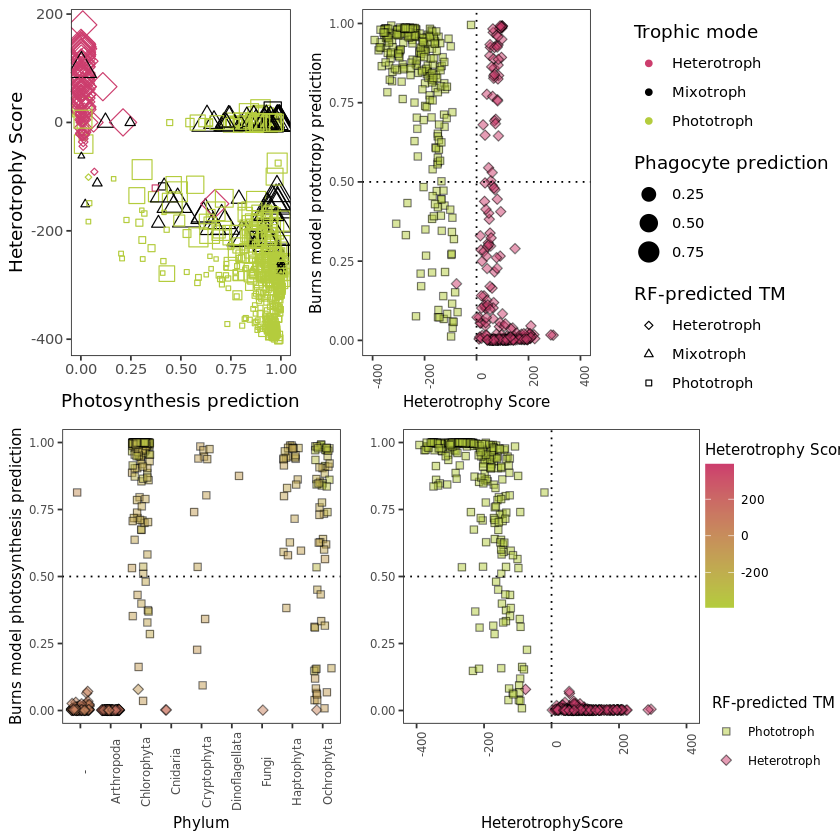

In [177]:
cowplot::plot_grid(cowplot::plot_grid(cowplot::plot_grid(burnsplot_2+theme(legend.position="none"),
                   burnsplot_4+theme(legend.position="none"),ncol=2,align="h"),
                   get_legend(burnsplot_2),rel_widths=c(1,0.4)),burnsplot_3,ncol=1)
ggsave(file.path("..","si-figures","burns-model-compare.png"),height=10,width=10,units="in",dpi=350)